For the Exploratory Data Analysis it may be complex to follow because there are a number of different datasets to consider. Firstly, the water data will be considered independently to understand trends, seasonality and cyclic behaviour as well as distributions and geospatial analysis. It is important that this is completed independently rather then on the merged dataset because through mergeing we have lost a lot of the data so the conclusions will be more valid based on the original data. 

For relationship analysis like correlation and scatter plots, we will used the merged data, to see how we merged and preprocessed all data, refer to the other files in the repository. 

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

## Read all the data into different dataframes. 

In [47]:
# read in the water data 
water = pd.read_csv('Water Data Pre-Processed.csv')
# read in the land use data 
landuse = pd.read_csv('land_use.csv')
# read the merged dataset 
merged = pd.read_csv('FINAL.csv')
# read the local authority boundaries data into a gdf 
boundaries = gpd.read_file("Local_Authority_Districts_December_2022_UK_BUC_V2_-1856850221694639751.geojson")

In [48]:

numeric_cols = water.select_dtypes(include='number').columns

# calculate Q1, Q3, and IQR for numeric columns
Q1 = water[numeric_cols].quantile(0.1)  
Q3 = water[numeric_cols].quantile(0.9) 
IQR = Q3 - Q1                        

# define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:\n", Q1, "\nQ3:\n", Q3, "\nIQR:\n", IQR)
print("\nLower Bound:\n", lower_bound, "\nUpper Bound:\n", upper_bound)

# replace outliers with Q1 or Q3 based on the condition
water_no_outliers = water.copy()

for col in numeric_cols:
    # replace values below the lower bound with Q1
    water_no_outliers[col] = water_no_outliers[col].apply(lambda x: Q1[col] if x < lower_bound[col] else x)
    # replace values above the upper bound with Q3
    water_no_outliers[col] = water_no_outliers[col].apply(lambda x: Q3[col] if x > upper_bound[col] else x)

print("\nOriginal DataFrame:")
print(water)

print("\nDataFrame with Replaced Outliers:")
print(water_no_outliers)
print(f"Original shape: {water.shape}, New shape: {water_no_outliers.shape}")


Q1:
 Unnamed: 0    1714168.20
northing        92953.00
easting        312662.00
result              0.03
year             2014.00
Name: 0.1, dtype: float64 
Q3:
 Unnamed: 0    17354113.20
northing        513438.00
easting         552173.00
result               8.63
year              2024.00
Name: 0.9, dtype: float64 
IQR:
 Unnamed: 0    15639945.0
northing        420485.0
easting         239511.0
result               8.6
year                10.0
dtype: float64

Lower Bound:
 Unnamed: 0   -21745749.30
northing       -537774.50
easting         -46604.50
result             -12.87
year              1999.00
dtype: float64 
Upper Bound:
 Unnamed: 0    40814030.70
northing       1144165.50
easting         911439.50
result              21.53
year              2039.00
dtype: float64

Original DataFrame:
         Unnamed: 0  compliance     sample_date_time  northing  easting  \
0                44       False  2014-01-20 12:29:00    241400   463800   
1                47       False  2014-01-20 

## General EDA of Water Data 

In [50]:
water_no_outliers.head()

Unnamed: 0  compliance     sample_date_time  northing  easting  \
0          44       False  2014-01-20 12:29:00    241400   463800   
1          47       False  2014-01-20 12:29:00    241400   463800   
2          51       False  2014-01-20 12:29:00    241400   463800   
3          56       False  2014-01-20 12:29:00    241400   463800   
4          59       False  2014-02-12 11:22:00    241400   463800   

  determinand_label             determinand_def  result determinand_unit  \
0      Sld Sus@105C  Solids, Suspended at 105 C  16.800             mg/l   
1                pH                          pH   8.000          phunits   
2        Ammonia(N)    Ammoniacal Nitrogen as N   0.036             mg/l   
3         Nitrate-N                Nitrate as N   4.270             mg/l   
4      Sld Sus@105C  Solids, Suspended at 105 C   8.630             mg/l   

                     sample_type  year  
0  RIVER / RUNNING SURFACE WATER  2014  
1  RIVER / RUNNING SURFACE WATER  2014  
2  RIVER / RUNNING SURFACE WATER  2014  
3  RIVER / RUNNING SURFACE WATER  2014  
4  RIVER / RUNNING SURFACE WATER  2014

In [51]:
water_no_outliers.shape

(1614739, 11)

In [52]:
water_no_outliers.describe()

Unnamed: 0      northing       easting        result          year
count  1.614739e+06  1.614739e+06  1.614739e+06  1.614739e+06  1.614739e+06
mean   9.718305e+06  2.889729e+05  4.261246e+05  4.523448e+00  2.018777e+03
std    5.629149e+06  1.564840e+05  9.766191e+04  4.069800e+00  3.468574e+00
min    4.400000e+01  1.000000e+00  1.359540e+05  0.000000e+00  2.014000e+03
25%    4.613774e+06  1.463930e+05  3.662510e+05  1.960000e-01  2.016000e+03
50%    1.032934e+07  2.896290e+05  4.261650e+05  4.070000e+00  2.019000e+03
75%    1.456654e+07  4.042380e+05  4.948610e+05  7.890000e+00  2.022000e+03
max    1.892598e+07  6.532430e+05  6.537000e+05  2.150000e+01  2.024000e+03

In [53]:
# check for nulls
print(water_no_outliers.isnull().sum())

Unnamed: 0           0
compliance           0
sample_date_time     0
northing             0
easting              0
determinand_label    0
determinand_def      0
result               0
determinand_unit     0
sample_type          0
year                 0
dtype: int64


In [54]:
# check dtypes
water_no_outliers.dtypes

Unnamed: 0             int64
compliance              bool
sample_date_time      object
northing               int64
easting                int64
determinand_label     object
determinand_def       object
result               float64
determinand_unit      object
sample_type           object
year                   int64
dtype: object

In [55]:
#change date time column to the appropriate dtype 
water_no_outliers['sample_date_time'] = pd.to_datetime(water['sample_date_time'])

## General EDA of Merged Data 

In [57]:
merged.head()

sample_date_time      local_authority_name  year  grand_total  \
0  2018-01-02 09:03:00            Northumberland  2018     507736.4   
1  2018-01-02 09:38:00                St. Helens  2018      13635.7   
2  2018-01-03 09:53:00  East Riding of Yorkshire  2018     249425.3   
3  2018-01-03 10:23:00  East Riding of Yorkshire  2018     249425.3   
4  2018-01-03 10:56:00  East Riding of Yorkshire  2018     249425.3   

   Ammonia(N)  BOD ATU  Nitrate-N  Sld Sus@105C    pH  industry_percentage  \
0       0.049     1.00       3.49          11.0  8.00             0.044767   
1       0.226     1.24       2.78          30.3  7.68             0.957780   
2       0.225     1.93       8.00         180.0  7.84             0.174361   
3       0.030     1.17       7.53         247.0  7.93             0.174361   
4       0.049     2.09       2.09          46.7  8.35             0.174361   

   minerals_percentage  residential_percentage  transport_percentage  \
0             0.042089                0.240262              1.972677   
1             0.343950                3.722581              8.541549   
2             0.066272                0.483111              2.761588   
3             0.066272                0.483111              2.761588   
4             0.066272                0.483111              2.761588   

   agriculture_percentage  
0               49.791289  
1               47.581716  
2               81.298529  
3               81.298529  
4               81.298529

In [58]:
merged.shape

(16394, 14)

In [59]:
merged.describe()

year    grand_total    Ammonia(N)       BOD ATU     Nitrate-N  \
count  16394.000000   16394.000000  16394.000000  16394.000000  16394.000000   
mean    2020.199402   70922.257369      0.540633      2.198489      6.132587   
std        1.281640   78914.742444     39.838032      3.680284      7.490048   
min     2018.000000    1904.000000      0.002000      1.000000      0.004000   
25%     2019.000000   18063.000000      0.030000      1.100000      2.200000   
50%     2020.000000   56693.000000      0.057000      1.540000      5.150000   
75%     2021.000000   92002.000000      0.160000      2.700000      8.330000   
max     2022.000000  507736.400000   5100.000000    290.000000    690.000000   

       Sld Sus@105C            pH  industry_percentage  minerals_percentage  \
count  16394.000000  16394.000000         16394.000000         16394.000000   
mean      18.401668      7.864860             0.523390             0.090370   
std       69.488021      0.358924             0.539349             0.267715   
min        1.800000      3.380000             0.020371             0.000000   
25%        4.800000      7.670000             0.153469             0.000000   
50%        7.900000      7.900000             0.286924             0.010751   
75%       15.000000      8.090000             0.749987             0.066407   
max     5600.000000     10.180000             5.272654             1.448730   

       residential_percentage  transport_percentage  agriculture_percentage  
count            16394.000000          16394.000000            16394.000000  
mean                 2.032301              5.584604               57.691560  
std                  2.224754              3.567458               19.919515  
min                  0.124370              1.484548                0.052493  
25%                  0.662453              3.604748               42.917123  
50%                  1.206317              4.214903               66.891332  
75%                  2.515791              6.307951               70.354779  
max                 18.067227             22.737840               85.709580

In [60]:
# check for nulls
print(merged.isnull().sum())

sample_date_time          0
local_authority_name      0
year                      0
grand_total               0
Ammonia(N)                0
BOD ATU                   0
Nitrate-N                 0
Sld Sus@105C              0
pH                        0
industry_percentage       0
minerals_percentage       0
residential_percentage    0
transport_percentage      0
agriculture_percentage    0
dtype: int64


In [61]:
# check dtypes
merged.dtypes

sample_date_time           object
local_authority_name       object
year                        int64
grand_total               float64
Ammonia(N)                float64
BOD ATU                   float64
Nitrate-N                 float64
Sld Sus@105C              float64
pH                        float64
industry_percentage       float64
minerals_percentage       float64
residential_percentage    float64
transport_percentage      float64
agriculture_percentage    float64
dtype: object

In [62]:
#change date time column to the appropriate dtype 
merged['sample_date_time'] = pd.to_datetime(merged['sample_date_time'])

## General Interesting Findings to Consider 

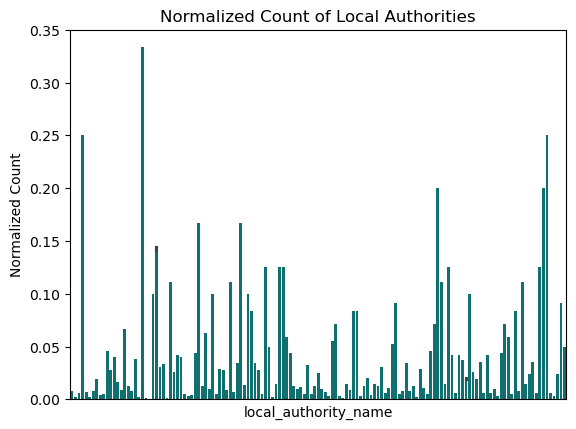

In [64]:
# normalize by dividing the count by the 'grand_total' column
merged['normalized_count'] = merged.groupby('local_authority_name')['grand_total'].transform(lambda x: x / x.sum())

# create the countplot with alphabetically ordered local authority names
sns.barplot(x=merged['local_authority_name'], y=merged['normalized_count'], order=sorted(merged['local_authority_name'].unique()), color='teal')

# remove the x-axis labels
plt.xticks([])

# set the title and y-axis label
plt.title("Normalized Count of Local Authorities")
plt.ylabel("Normalized Count")

plt.show()


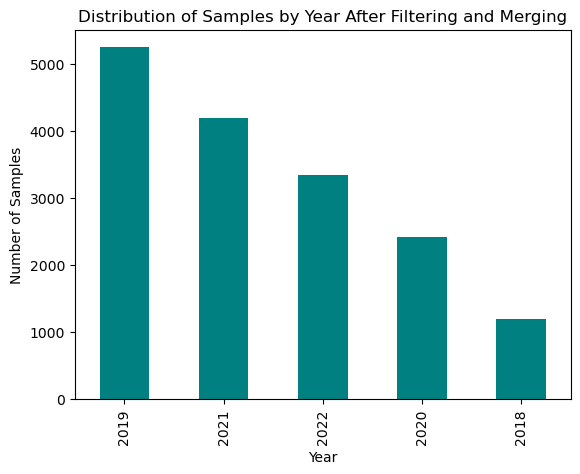

In [65]:
merged['year'].value_counts().plot(kind='bar', color='teal')
plt.title('Distribution of Samples by Year After Filtering and Merging') 
plt.xlabel('Year')  
plt.ylabel('Number of Samples') 
plt.show() 


## Time Series Analysis 

Plotting time series for each parameter with a moving average, with outliers removed. 

To be better understand the plots, we have plotted a following graph to understand the blocks of colout better, some log transformations have been used where it prived better visualisation. 

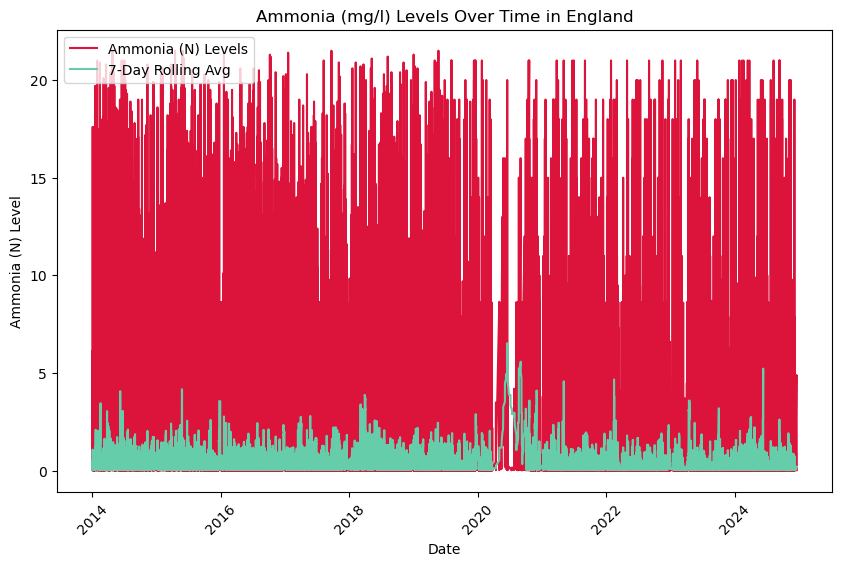

In [68]:
# filter for Ammonia(N) measurements
df_ammonia = water_no_outliers[water_no_outliers["determinand_label"] == "Ammonia(N)"].copy()

# sort values by time (optional but recommended)
df_ammonia = df_ammonia.sort_values(by="sample_date_time")

# compute rolling average (7-day window)
df_ammonia["rolling_avg"] = df_ammonia["result"].rolling(window=30, min_periods=1).mean()

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points
ax.plot(df_ammonia["sample_date_time"], df_ammonia["result"], color="crimson", label="Ammonia (N) Levels")

# plot rolling average
ax.plot(df_ammonia["sample_date_time"], df_ammonia["rolling_avg"], color="mediumaquamarine", label="7-Day Rolling Avg")

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Ammonia (N) Level")
ax.set_title("Ammonia (mg/l) Levels Over Time in England")
plt.xticks(rotation=45) 
ax.legend() 

plt.show()


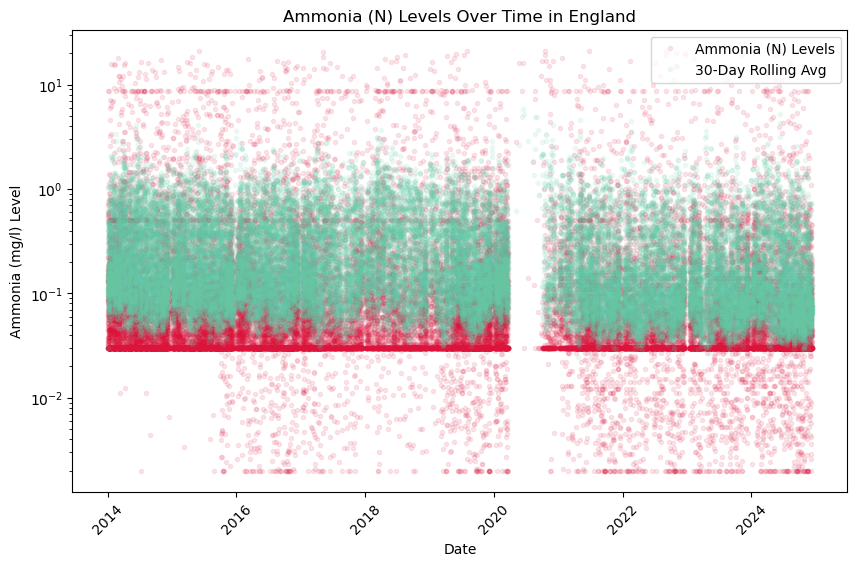

In [69]:

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points without lines, smaller and transparent markers
ax.plot(df_ammonia["sample_date_time"][::10], df_ammonia["result"][::10], 
        marker='o', color="crimson", label="Ammonia (N) Levels", markersize=3, alpha=0.1, linestyle='')

# plot rolling average without lines, smaller and transparent markers
ax.plot(df_ammonia["sample_date_time"][::10], df_ammonia["rolling_avg"][::10], 
        marker='o', color="mediumaquamarine", label="30-Day Rolling Avg", markersize=3, alpha=0.1, linestyle='')

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Ammonia (mg/l) Level")
ax.set_title("Ammonia (N) Levels Over Time in England")

# set the y-axis to log scale
ax.set_yscale('log')

# rotate x-axis labels for readability
plt.xticks(rotation=45)

# show legend
ax.legend()

# display the plot
plt.show()


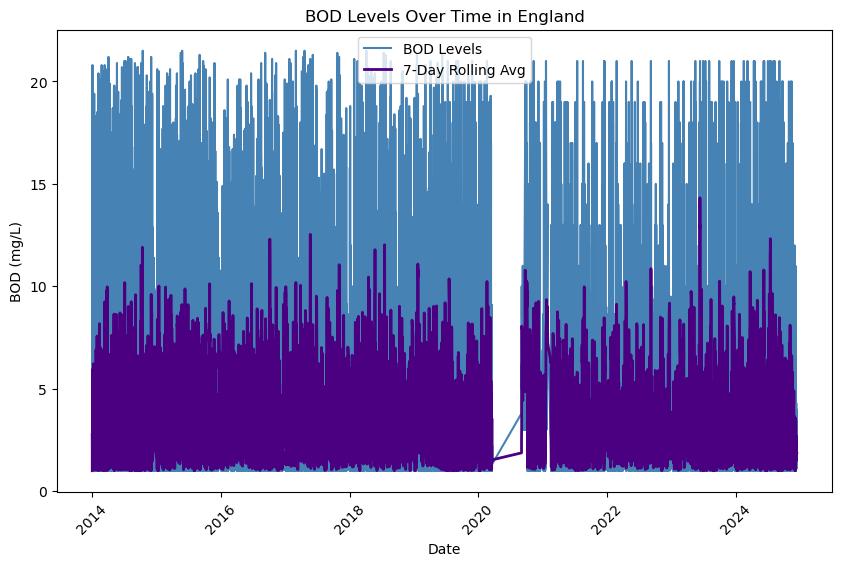

In [70]:
# filter for BOD ATU measurements
df_bod = water_no_outliers[water_no_outliers["determinand_label"] == "BOD ATU"].copy()
# sort values by time (optional but recommended)
df_bod = df_bod.sort_values(by="sample_date_time")

# compute rolling average (7-day window)
df_bod["rolling_avg"] = df_bod["result"].rolling(window=7, min_periods=1).mean()

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points
ax.plot(df_bod["sample_date_time"], df_bod["result"], linestyle="-", color="steelblue", label="BOD Levels")

# plot rolling average
ax.plot(df_bod["sample_date_time"], df_bod["rolling_avg"], linestyle="-", color="indigo", linewidth=2, label="7-Day Rolling Avg")

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("BOD (mg/L)")
ax.set_title("BOD Levels Over Time in England")
plt.xticks(rotation=45) 
ax.legend()  

plt.show()

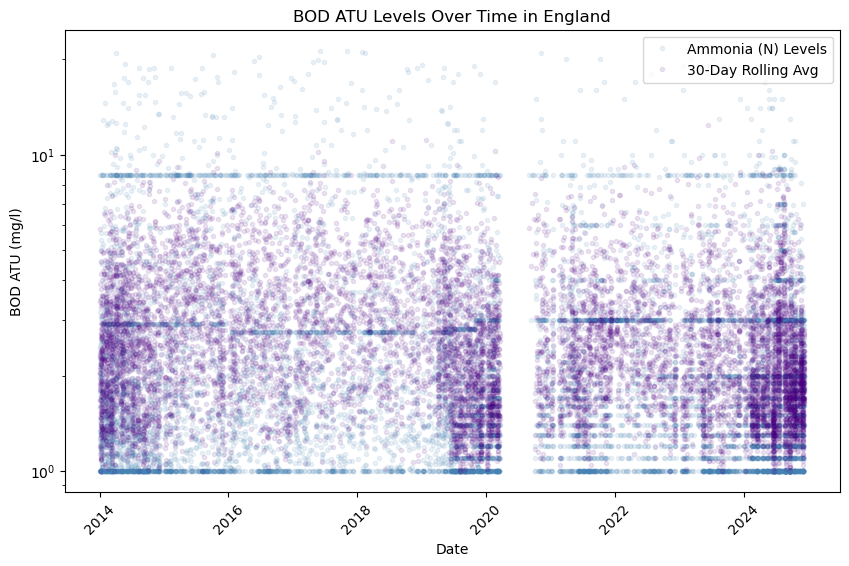

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points without lines, smaller and transparent markers
ax.plot(df_bod["sample_date_time"][::10], df_bod["result"][::10], 
        marker='o', color="steelblue", label="Ammonia (N) Levels", markersize=3, alpha=0.1, linestyle='')

# plot rolling average without lines, smaller and transparent markers
ax.plot(df_bod["sample_date_time"][::10], df_bod["rolling_avg"][::10], 
        marker='o', color="indigo", label="30-Day Rolling Avg", markersize=3, alpha=0.1, linestyle='')

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("BOD ATU (mg/l)")
ax.set_title("BOD ATU Levels Over Time in England")
# set the y-axis to log scale
ax.set_yscale('log')
plt.xticks(rotation=45)
ax.legend()

plt.show()


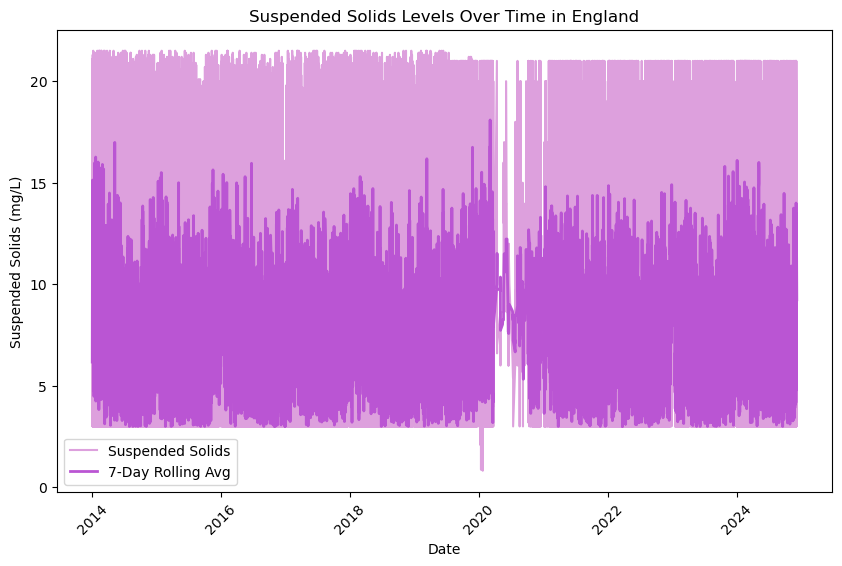

In [72]:
# filter for Suspended Solids (Sld Sus@105C) measurements
df_ss = water_no_outliers[water_no_outliers["determinand_label"] == "Sld Sus@105C"].copy()

# sort values by time (optional but recommended)
df_ss = df_ss.sort_values(by="sample_date_time")

# compute rolling average (7-day window)
df_ss["rolling_avg"] = df_ss["result"].rolling(window=7, min_periods=1).mean()

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points
ax.plot(df_ss["sample_date_time"], df_ss["result"],  linestyle="-", color="plum", label="Suspended Solids")

# plot rolling average
ax.plot(df_ss["sample_date_time"], df_ss["rolling_avg"], linestyle="-", color="mediumorchid", linewidth=2, label="7-Day Rolling Avg")

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Suspended Solids (mg/L)")
ax.set_title("Suspended Solids Levels Over Time in England")
plt.xticks(rotation=45)  
ax.legend()  

plt.show()


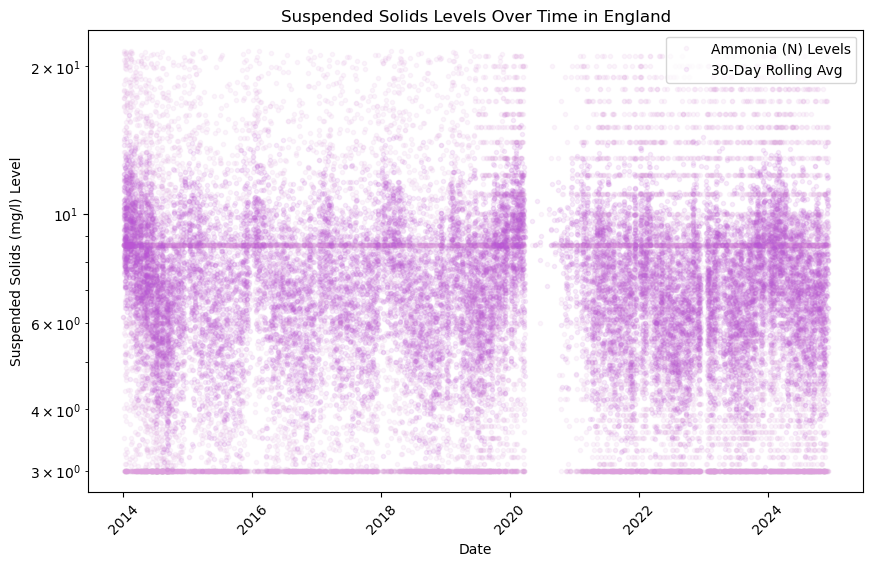

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points without lines, smaller and transparent markers
ax.plot(df_ss["sample_date_time"][::10], df_ss["result"][::10], 
        marker='o', color="plum", label="Ammonia (N) Levels", markersize=3, alpha=0.1, linestyle='')

# plot rolling average without lines, smaller and transparent markers
ax.plot(df_ss["sample_date_time"][::10], df_ss["rolling_avg"][::10], 
        marker='o', color="mediumorchid", label="30-Day Rolling Avg", markersize=3, alpha=0.1, linestyle='')

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Suspended Solids (mg/l) Level")
ax.set_title("Suspended Solids Levels Over Time in England")
ax.set_yscale('log')
plt.xticks(rotation=45)
ax.legend()

plt.show()


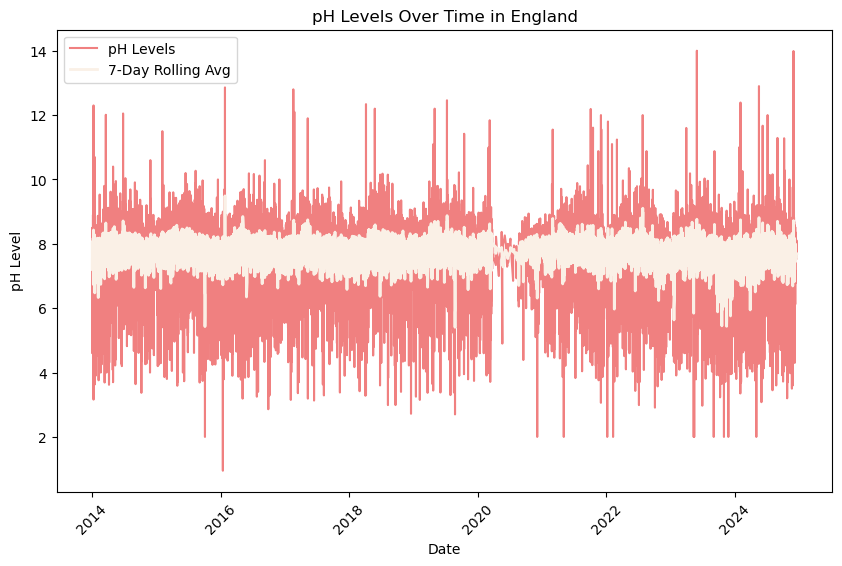

In [74]:
# filter for pH measurements
df_ph = water_no_outliers[water_no_outliers["determinand_label"] == "pH"].copy()

# sort values by time 
df_ph = df_ph.sort_values(by="sample_date_time")

# compute rolling average (7-day window)
df_ph["rolling_avg"] = df_ph["result"].rolling(window=7, min_periods=1).mean()

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points
ax.plot(df_ph["sample_date_time"], df_ph["result"], linestyle="-", color="lightcoral", label="pH Levels")

# plot rolling average
ax.plot(df_ph["sample_date_time"], df_ph["rolling_avg"], linestyle="-", color="linen", linewidth=2, label="7-Day Rolling Avg")

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("pH Level")
ax.set_title("pH Levels Over Time in England")
plt.xticks(rotation=45)  
ax.legend() 

plt.show()


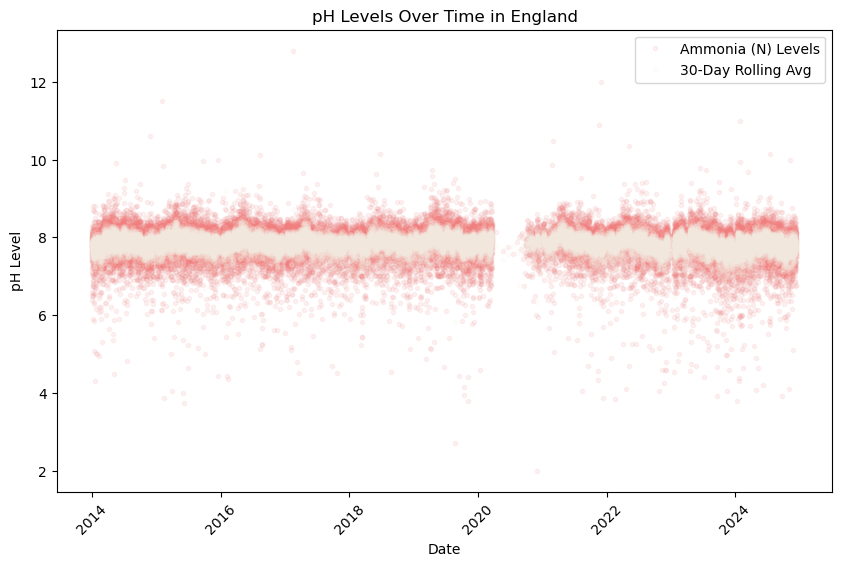

In [75]:
# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points without lines, smaller and transparent markers
ax.plot(df_ph["sample_date_time"][::10], df_ph["result"][::10], 
        marker='o', color="lightcoral", label="Ammonia (N) Levels", markersize=3, alpha=0.1, linestyle='')

# plot rolling average without lines, smaller and transparent markers
ax.plot(df_ph["sample_date_time"][::10], df_ph["rolling_avg"][::10], 
        marker='o', color="linen", label="30-Day Rolling Avg", markersize=3, alpha=0.1, linestyle='')

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("pH Level")
ax.set_title("pH Levels Over Time in England")
plt.xticks(rotation=45)
ax.legend()

plt.show()


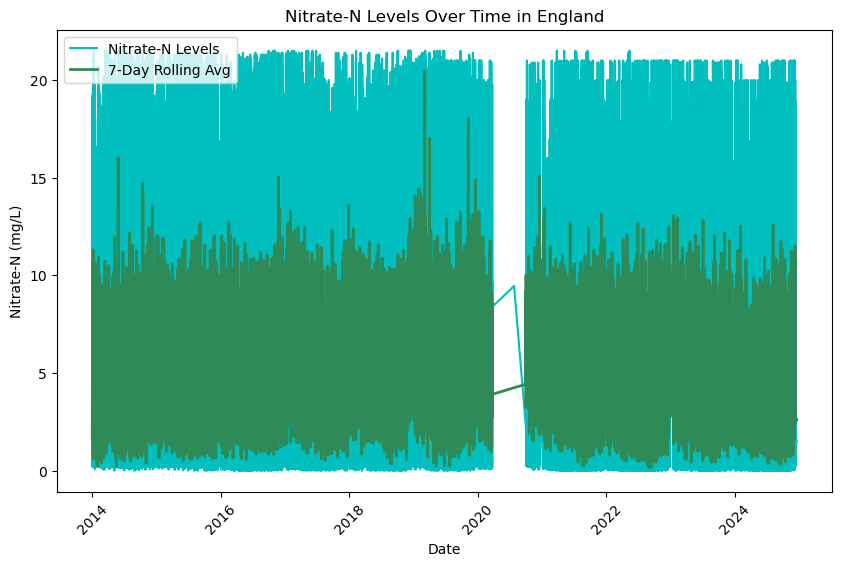

In [76]:
# filter for Nitrate-N measurements
df_nitrate = water_no_outliers[water_no_outliers["determinand_label"] == "Nitrate-N"].copy()

# sort values by time (optional but recommended)
df_nitrate = df_nitrate.sort_values(by="sample_date_time")

# compute rolling average (7-day window)
df_nitrate["rolling_avg"] = df_nitrate["result"].rolling(window=7, min_periods=1).mean()

# plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points
ax.plot(df_nitrate["sample_date_time"], df_nitrate["result"], linestyle="-", color="c", label="Nitrate-N Levels")

# plot rolling average
ax.plot(df_nitrate["sample_date_time"], df_nitrate["rolling_avg"], linestyle="-", color="seagreen", linewidth=2, label="7-Day Rolling Avg")

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Nitrate-N (mg/L)")
ax.set_title("Nitrate-N Levels Over Time in England")
plt.xticks(rotation=45) 
ax.legend()  

plt.show()

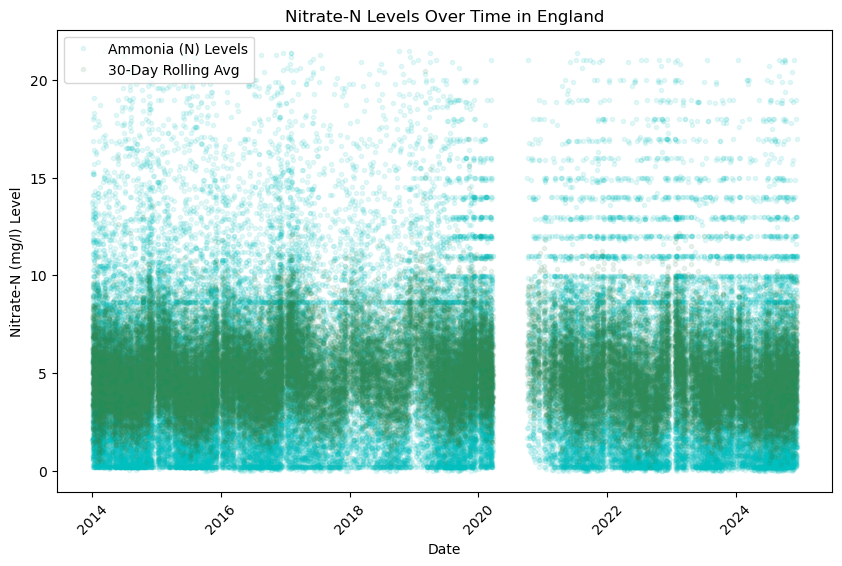

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot original data points without lines, smaller and transparent markers
ax.plot(df_nitrate["sample_date_time"][::10], df_nitrate["result"][::10], 
        marker='o', color="c", label="Ammonia (N) Levels", markersize=3, alpha=0.1, linestyle='')

# plot rolling average without lines, smaller and transparent markers
ax.plot(df_nitrate["sample_date_time"][::10], df_nitrate["rolling_avg"][::10], 
        marker='o', color="seagreen", label="30-Day Rolling Avg", markersize=3, alpha=0.1, linestyle='')

# formatting
ax.set_xlabel("Date")
ax.set_ylabel("Nitrate-N (mg/l) Level")
ax.set_title("Nitrate-N Levels Over Time in England")
plt.xticks(rotation=45)
ax.legend()

plt.show()

## Seasonality 

In [79]:
water_wide = water_no_outliers.pivot_table(
    index=['sample_date_time', 'northing', 'easting', 
       'sample_type', 'year'],
    columns="determinand_label",
    values="result",
    aggfunc="first"
).reset_index()
#drop rows that do not have all paramateres measured so df only contains sampling points where all the parameters have been measured and theres no missing data 
water_reshaped = water_wide.dropna().copy()


In [80]:
water_reshaped.head()

determinand_label    sample_date_time  northing  easting  \
1                 2014-01-02 07:48:00    288663   632717   
4                 2014-01-02 08:06:00    341994   462172   
5                 2014-01-02 08:12:00    341877   462258   
8                 2014-01-02 08:30:00    208900   435383   
13                2014-01-02 08:52:00    208353   435652   

determinand_label                    sample_type  year  Ammonia(N)  BOD ATU  \
1                  RIVER / RUNNING SURFACE WATER  2014       0.072     1.00   
4                  RIVER / RUNNING SURFACE WATER  2014       0.500     1.20   
5                  RIVER / RUNNING SURFACE WATER  2014       0.500     2.06   
8                  RIVER / RUNNING SURFACE WATER  2014       0.030     1.00   
13                 RIVER / RUNNING SURFACE WATER  2014       0.797     4.30   

determinand_label  Nitrate-N  Sld Sus@105C    pH  
1                      12.40         18.10  8.02  
4                       4.57         12.70  8.03  
5                       6.94         12.60  7.81  
8                       6.73          5.77  7.33  
13                      7.07         19.30  7.54

In [81]:
water_reshaped.shape

(33610, 10)

In [82]:
parameters = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']


==== Seasonality Analysis for Ammonia(N) ====
[ADF Test on Seasonality]
ADF Statistic: -51.842, p-value: 0.000
[Kruskal-Wallis Test on Seasonality]
Kruskal-Wallis Statistic: 0.004, p-value: 0.998

==== Seasonality Analysis for BOD ATU ====
[ADF Test on Seasonality]
ADF Statistic: -30.168, p-value: 0.000
[Kruskal-Wallis Test on Seasonality]
Kruskal-Wallis Statistic: 0.025, p-value: 0.988

==== Seasonality Analysis for Nitrate-N ====
[ADF Test on Seasonality]
ADF Statistic: -98.578, p-value: 0.000
[Kruskal-Wallis Test on Seasonality]
Kruskal-Wallis Statistic: 0.000, p-value: 1.000

==== Seasonality Analysis for Sld Sus@105C ====
[ADF Test on Seasonality]
ADF Statistic: -69.564, p-value: 0.000
[Kruskal-Wallis Test on Seasonality]
Kruskal-Wallis Statistic: 0.001, p-value: 0.999

==== Seasonality Analysis for pH ====
[ADF Test on Seasonality]
ADF Statistic: -109.324, p-value: 0.000
[Kruskal-Wallis Test on Seasonality]
Kruskal-Wallis Statistic: 0.000, p-value: 1.000


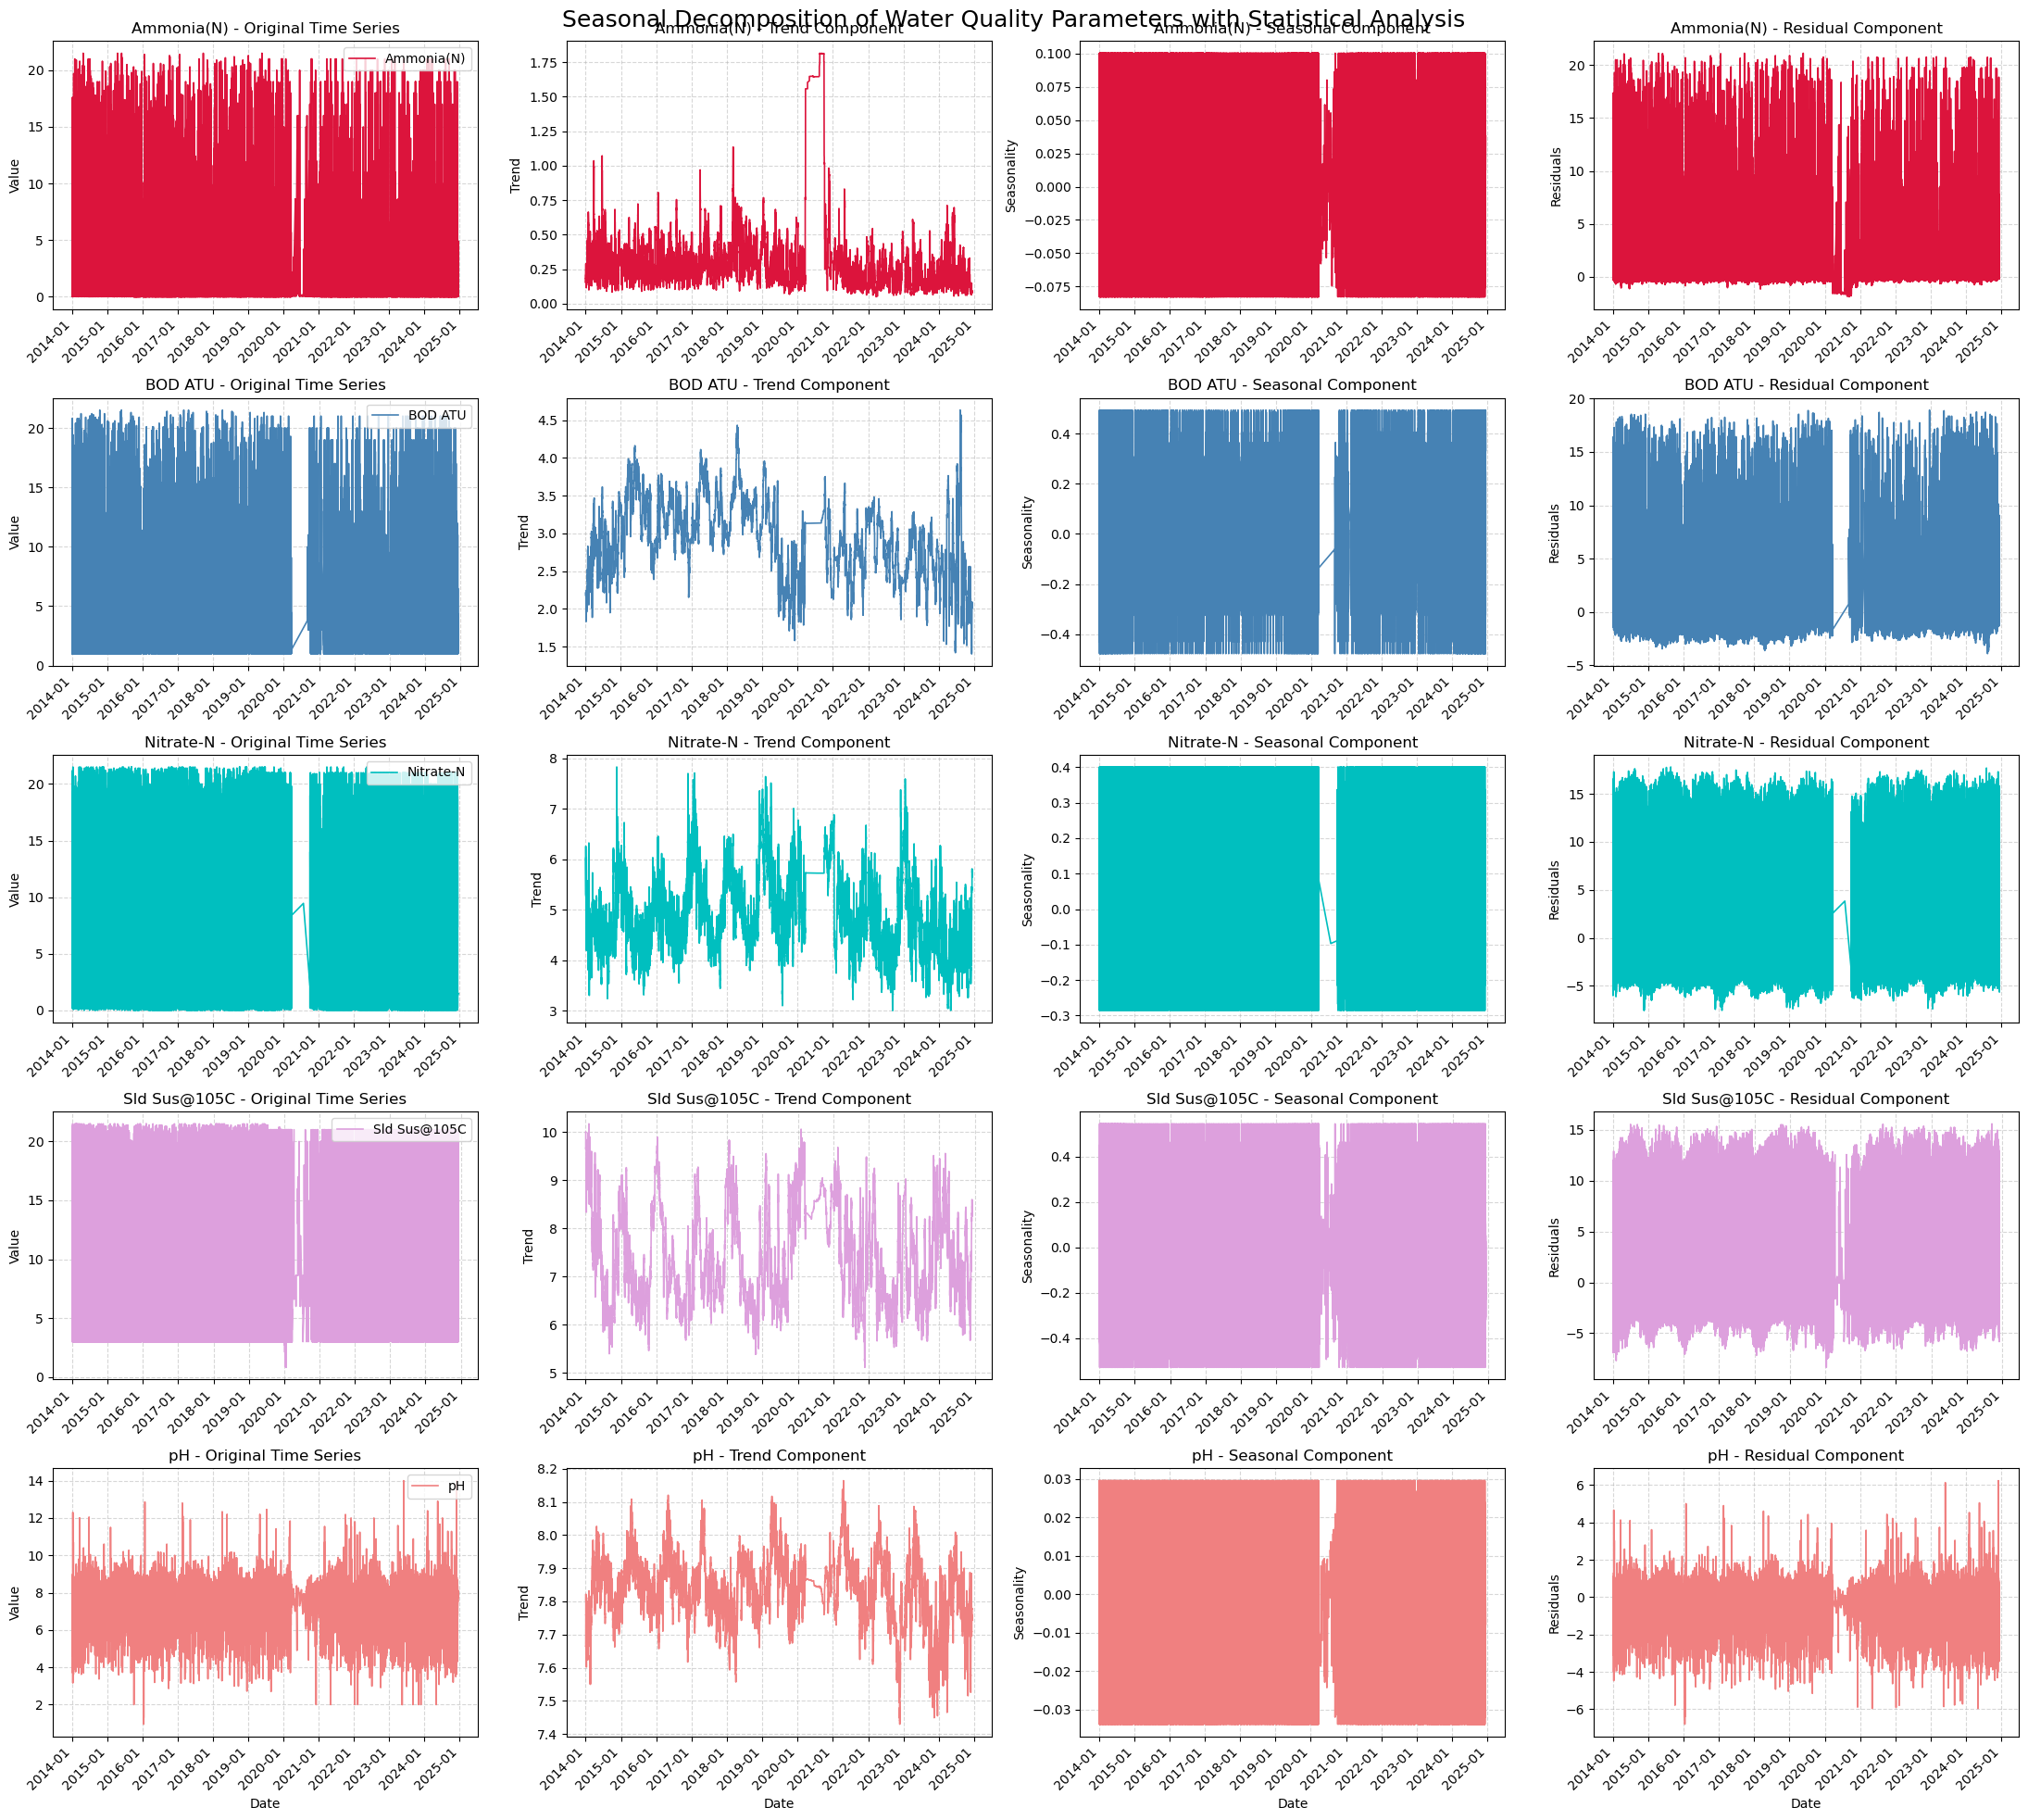


=== Seasonality Statistical Test Results ===
      Parameter  ADF_Stationary  Kruskal_Seasonal
0    Ammonia(N)            True             False
1       BOD ATU            True             False
2     Nitrate-N            True             False
3  Sld Sus@105C            True             False
4            pH            True             False


In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kruskal
import matplotlib.dates as mdates


parameters = ["Ammonia(N)", "BOD ATU", "Nitrate-N", "Sld Sus@105C", "pH"]
color_map = {
    "Ammonia(N)": "crimson",
    "BOD ATU": "steelblue",
    "Nitrate-N": "c",   
    "Sld Sus@105C": "plum",
    "pH": "lightcoral"
}

# list of dfs
dfs = [df_ammonia, df_bod, df_nitrate, df_ss, df_ph]
n_params = len(dfs)

# ensure datetime index for all DataFrames
for df in dfs:
    df.index = pd.to_datetime(df['sample_date_time'])

#adf function
def adf_test(series, alpha=0.05):
    """Performs Augmented Dickey-Fuller test."""
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.3f}, p-value: {result[1]:.3f}")
    return result[1] < alpha  # stationary if p-value < alpha
    
#kw function 
def kruskal_wallis_test(series, alpha=0.05):
    """Performs Kruskal-Wallis test on 3 time-based groups."""
    length = len(series.dropna())
    if length < 3:
        print("Not enough data for Kruskal-Wallis test.")
        return False

    split_size = length // 3
    groups = [series.iloc[i * split_size: (i + 1) * split_size] for i in range(3)]

    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis Statistic: {stat:.3f}, p-value: {p_value:.3f}")
    return p_value < alpha  # significant seasonality if p-value < alpha

fig, axes = plt.subplots(nrows=n_params, ncols=4, figsize=(22, 20))

# store the test results
seasonality_test_results = pd.DataFrame(columns=['Parameter', 'ADF_Stationary', 'Kruskal_Seasonal'])

#loop through dfs for decomp
for i, (df, col) in enumerate(zip(dfs, parameters)):
    # Get color for the parameter (fallback to blue if missing)
    color = color_map.get(col, 'blue')

    # original Time Series
    axes[i, 0].plot(df.index, df['result'], label=col, color=color, linewidth=1.2)
    axes[i, 0].set_title(f"{col} - Original Time Series", fontsize=12)
    axes[i, 0].set_ylabel("Value", fontsize=10)
    axes[i, 0].grid(True, linestyle='--', alpha=0.5)
    axes[i, 0].legend(loc="upper right")

    #seasonal decomposition
    decomposition = seasonal_decompose(df['result'], model='additive', period=365)

    #trend Component 
    axes[i, 1].plot(decomposition.trend.index, decomposition.trend, color=color, linewidth=1.2)
    axes[i, 1].set_title(f"{col} - Trend Component", fontsize=12)
    axes[i, 1].set_ylabel("Trend", fontsize=10)
    axes[i, 1].grid(True, linestyle='--', alpha=0.5)

    #seasonal component
    axes[i, 2].plot(decomposition.seasonal.index, decomposition.seasonal, color=color, linewidth=1.2)
    axes[i, 2].set_title(f"{col} - Seasonal Component", fontsize=12)
    axes[i, 2].set_ylabel("Seasonality", fontsize=10)
    axes[i, 2].grid(True, linestyle='--', alpha=0.5)

    #residual component
    axes[i, 3].plot(decomposition.resid.index, decomposition.resid, color=color, linewidth=1.2)
    axes[i, 3].set_title(f"{col} - Residual Component", fontsize=12)
    axes[i, 3].set_ylabel("Residuals", fontsize=10)
    axes[i, 3].grid(True, linestyle='--', alpha=0.5)

    # apply ADF and KW on seasonal component
    print(f"\n==== Seasonality Analysis for {col} ====")

    print("[ADF Test on Seasonality]")
    adf_stationary = adf_test(decomposition.seasonal)

    print("[Kruskal-Wallis Test on Seasonality]")
    kruskal_seasonal = kruskal_wallis_test(decomposition.seasonal)

    # store test results
    seasonality_test_results.loc[len(seasonality_test_results)] = [
        col, adf_stationary, kruskal_seasonal
    ]

    for j in range(4):
        if i == n_params - 1:
            axes[i, j].set_xlabel("Date", fontsize=10)
        else:
            axes[i, j].set_xlabel("")

        axes[i, j].xaxis.set_major_locator(mdates.YearLocator())
        axes[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(axes[i, j].get_xticklabels(), rotation=45, ha='right')

fig.suptitle("Seasonal Decomposition of Water Quality Parameters with Statistical Analysis", 
             fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

print("\n=== Seasonality Statistical Test Results ===")
print(seasonality_test_results)


## Correlation Analysis using merged dataset

In [85]:

# calculate Q1, Q3, and IQR for numeric columns
Q1 = merged[parameters].quantile(0.1)  # First quartile (25th percentile)
Q3 = merged[parameters].quantile(0.9)  # Third quartile (75th percentile)
IQR = Q3 - Q1                         # Interquartile range

# define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:\n", Q1, "\nQ3:\n", Q3, "\nIQR:\n", IQR)
print("\nLower Bound:\n", lower_bound, "\nUpper Bound:\n", upper_bound)

# replace outliers with Q1 or Q3 based on the condition
merged_no_outliers = merged.copy()

for col in parameters:
    # replace values below the lower bound with Q1
    merged_no_outliers[col] = merged_no_outliers[col].apply(lambda x: Q1[col] if x < lower_bound[col] else x)
    # replace values above the upper bound with Q3
    merged_no_outliers[col] = merged_no_outliers[col].apply(lambda x: Q3[col] if x > upper_bound[col] else x)

print("\nOriginal DataFrame:")
print(water)

print("\nDataFrame with Replaced Outliers:")
print(water_no_outliers)
print(f"Original shape: {water.shape}, New shape: {water_no_outliers.shape}")


Q1:
 Ammonia(N)      0.030
BOD ATU         1.000
Nitrate-N       0.817
Sld Sus@105C    3.000
pH              7.430
Name: 0.1, dtype: float64 
Q3:
 Ammonia(N)       0.43
BOD ATU          3.60
Nitrate-N       12.00
Sld Sus@105C    33.00
pH               8.25
Name: 0.9, dtype: float64 
IQR:
 Ammonia(N)       0.400
BOD ATU          2.600
Nitrate-N       11.183
Sld Sus@105C    30.000
pH               0.820
dtype: float64

Lower Bound:
 Ammonia(N)      -0.5700
BOD ATU         -2.9000
Nitrate-N      -15.9575
Sld Sus@105C   -42.0000
pH               6.2000
dtype: float64 
Upper Bound:
 Ammonia(N)       1.0300
BOD ATU          7.5000
Nitrate-N       28.7745
Sld Sus@105C    78.0000
pH               9.4800
dtype: float64

Original DataFrame:
         Unnamed: 0  compliance     sample_date_time  northing  easting  \
0                44       False  2014-01-20 12:29:00    241400   463800   
1                47       False  2014-01-20 12:29:00    241400   463800   
2                51       False  2

In [86]:
merged_no_outliers.head()

sample_date_time      local_authority_name  year  grand_total  \
0 2018-01-02 09:03:00            Northumberland  2018     507736.4   
1 2018-01-02 09:38:00                St. Helens  2018      13635.7   
2 2018-01-03 09:53:00  East Riding of Yorkshire  2018     249425.3   
3 2018-01-03 10:23:00  East Riding of Yorkshire  2018     249425.3   
4 2018-01-03 10:56:00  East Riding of Yorkshire  2018     249425.3   

   Ammonia(N)  BOD ATU  Nitrate-N  Sld Sus@105C    pH  industry_percentage  \
0       0.049     1.00       3.49          11.0  8.00             0.044767   
1       0.226     1.24       2.78          30.3  7.68             0.957780   
2       0.225     1.93       8.00          33.0  7.84             0.174361   
3       0.030     1.17       7.53          33.0  7.93             0.174361   
4       0.049     2.09       2.09          46.7  8.35             0.174361   

   minerals_percentage  residential_percentage  transport_percentage  \
0             0.042089                0.240262              1.972677   
1             0.343950                3.722581              8.541549   
2             0.066272                0.483111              2.761588   
3             0.066272                0.483111              2.761588   
4             0.066272                0.483111              2.761588   

   agriculture_percentage  normalized_count  
0               49.791289          0.014173  
1               47.581716          0.005618  
2               81.298529          0.005091  
3               81.298529          0.005091  
4               81.298529          0.005091

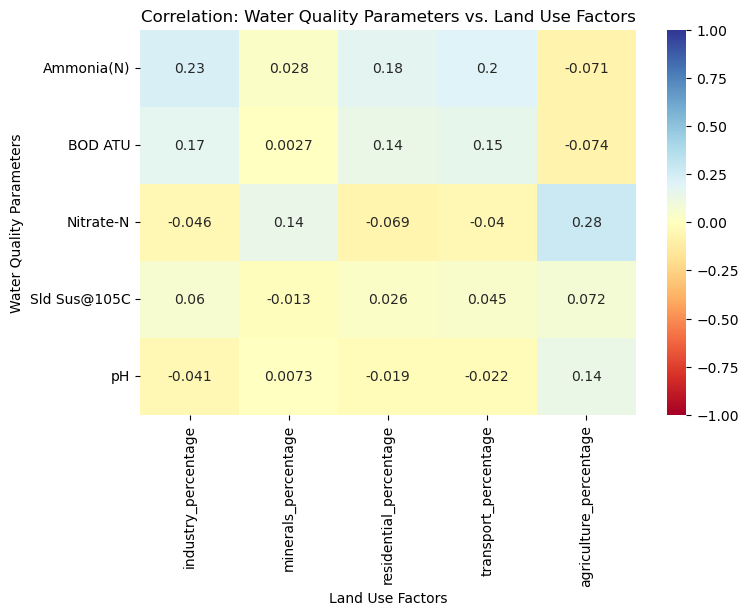

In [87]:
param_cols = ["Ammonia(N)", "BOD ATU", "Nitrate-N", "Sld Sus@105C", "pH"]
land_cols = ["industry_percentage", "minerals_percentage", "residential_percentage", 
             "transport_percentage", "agriculture_percentage"]

# subset the df to just these columns
subset_cols = param_cols + land_cols
df_subset = merged_no_outliers[subset_cols].dropna()

# compute the correlation matrix for the subset
corr_full = df_subset.corr()

# slice the correlation matrix to keep only rows from parameters and columns from land use
corr_param_land = corr_full.loc[param_cols, land_cols]

# focusing on water quality parameters
plt.figure(figsize=(8, 5))

sns.heatmap(
    corr_param_land,
    annot=True,
    cmap="RdYlBu",
    vmin=-1, vmax=1
)

plt.title("Correlation: Water Quality Parameters vs. Land Use Factors")
plt.xlabel("Land Use Factors")
plt.ylabel("Water Quality Parameters")
plt.show()

## Scatter Plots 

In [89]:
factors = ['industry_percentage', 'minerals_percentage', 'residential_percentage', 'transport_percentage', 'agriculture_percentage']

In [90]:
largest_values = {}
smallest_values = {}

for factor in factors:
    largest_values[factor] = merged_no_outliers.nlargest(500, factor, keep='first')
    smallest_values[factor] = merged_no_outliers.nsmallest(500, factor, keep='first')


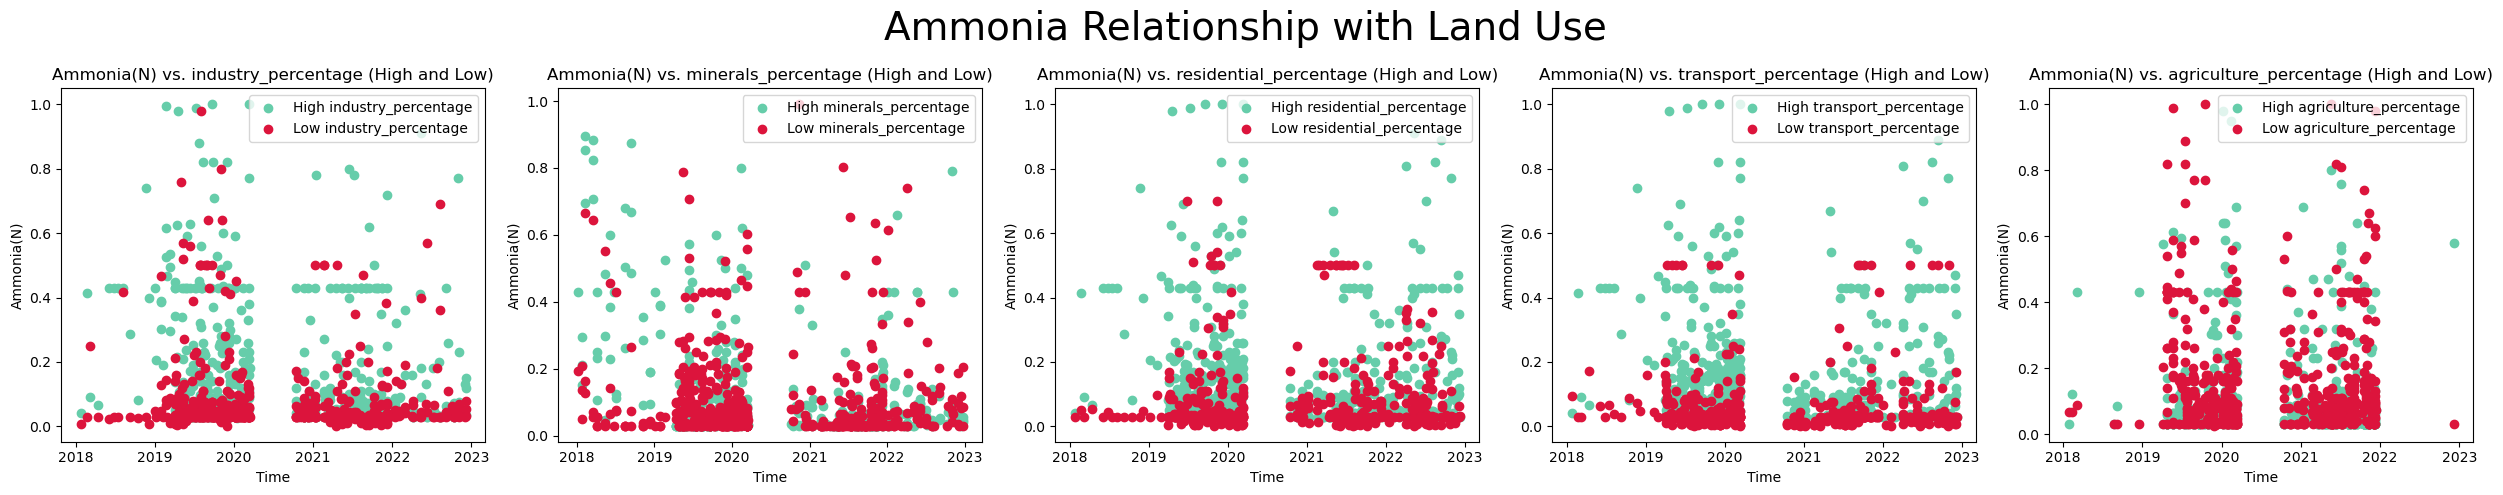

In [91]:
# create subplots with fewer rows but more columns for side-by-side placement
ncols = len(factors)  
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

# ensure axes is iterable 
axes = axes if isinstance(axes, np.ndarray) else [axes]

# loop through the factors to create each subplot
for i, factor in enumerate(factors):
    ax = axes[i]

    ammonia_high = largest_values[factor]["Ammonia(N)"].values
    ammonia_low = smallest_values[factor]["Ammonia(N)"].values

    time = largest_values[factor]["sample_date_time"].values  
    # scatter plot for both high and low values together
    ax.scatter(time, ammonia_high, color='mediumaquamarine', label='High ' + factor)
    ax.scatter(time, ammonia_low, color='crimson', label='Low ' + factor)

    ax.set_title(f"Ammonia(N) vs. {factor} (High and Low)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Ammonia(N)")
    ax.legend()
fig.suptitle('Ammonia Relationship with Land Use', fontsize=28)
plt.tight_layout() 
plt.show()


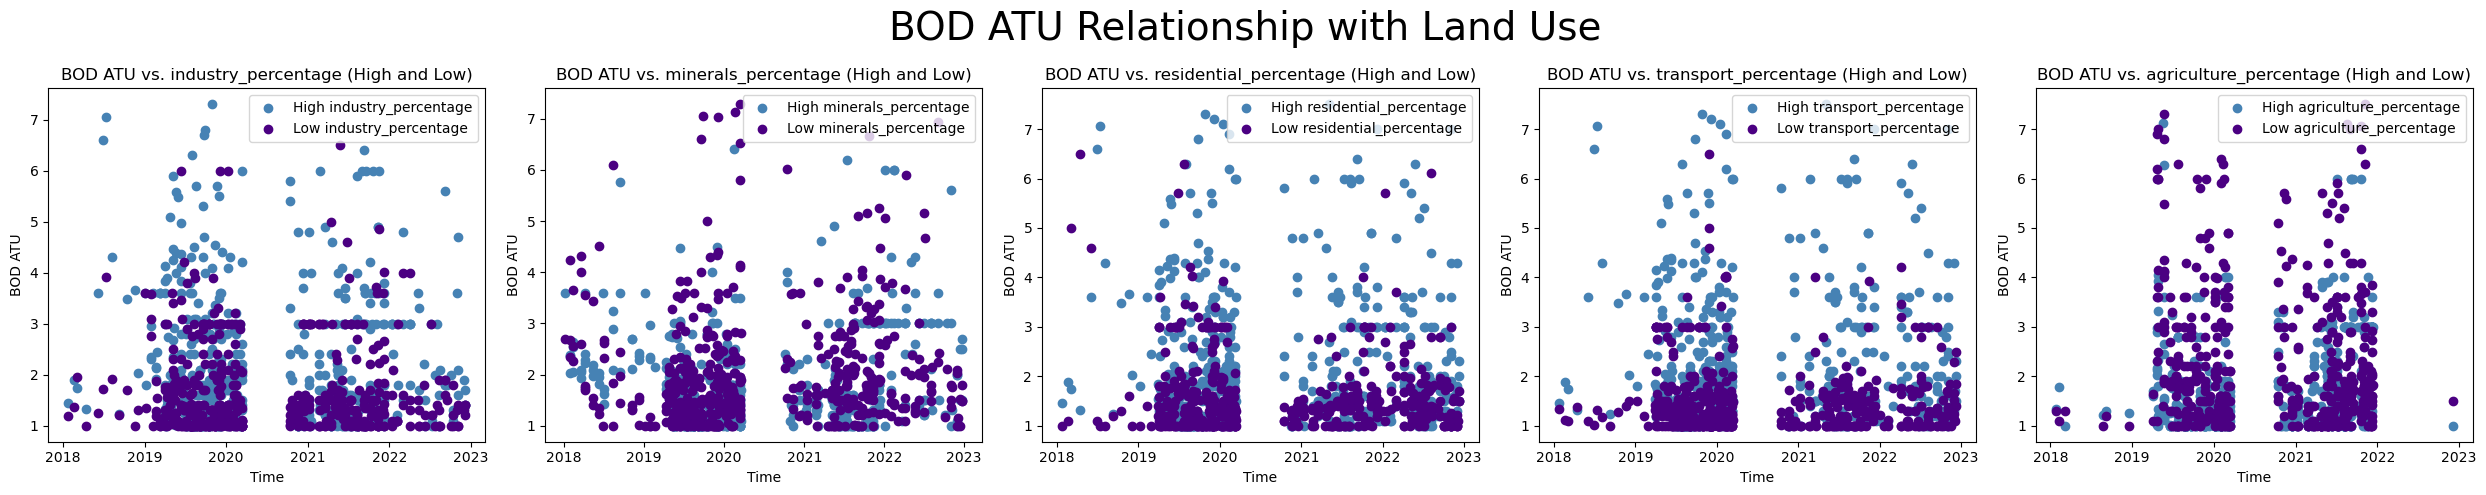

In [92]:
ncols = len(factors) 
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

axes = axes if isinstance(axes, np.ndarray) else [axes]

#loop through the factors to create each subplot
for i, factor in enumerate(factors):
    ax = axes[i]

    BOD_high = largest_values[factor]["BOD ATU"].values
    BOD_low = smallest_values[factor]["BOD ATU"].values

    time = largest_values[factor]["sample_date_time"].values  
    
    # scatter plot for both high and low values together
    ax.scatter(time, BOD_high, color='steelblue', label='High ' + factor)
    ax.scatter(time, BOD_low, color='indigo', label='Low ' + factor)

    ax.set_title(f"BOD ATU vs. {factor} (High and Low)")
    ax.set_xlabel("Time")
    ax.set_ylabel("BOD ATU")
    ax.legend()
fig.suptitle('BOD ATU Relationship with Land Use', fontsize=28)
plt.tight_layout()  
plt.show()


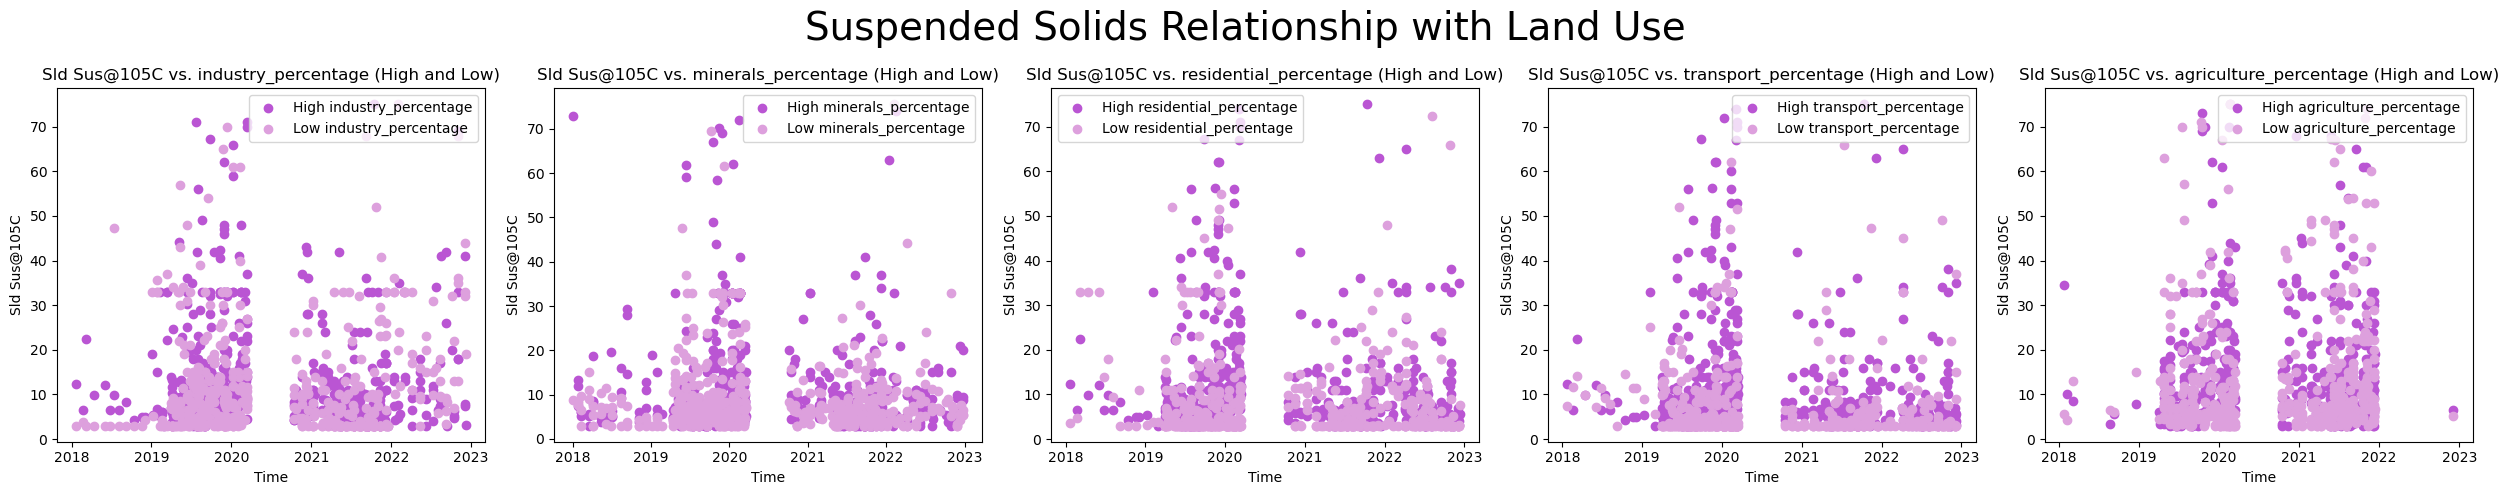

In [93]:
ncols = len(factors) 
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

axes = axes if isinstance(axes, np.ndarray) else [axes]

# loop through the factors to create each subplot
for i, factor in enumerate(factors):
    ax = axes[i]

    solids_high = largest_values[factor]["Sld Sus@105C"].values
    solids_low = smallest_values[factor]["Sld Sus@105C"].values

    time = largest_values[factor]["sample_date_time"].values  
    
    # scatter plot for both high and low values together
    ax.scatter(time, solids_high, color='mediumorchid', label='High ' + factor)
    ax.scatter(time, solids_low, color='plum', label='Low ' + factor)

    ax.set_title(f"Sld Sus@105C vs. {factor} (High and Low)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Sld Sus@105C")
    ax.legend()
fig.suptitle('Suspended Solids Relationship with Land Use', fontsize=28)
plt.tight_layout() 
plt.show()


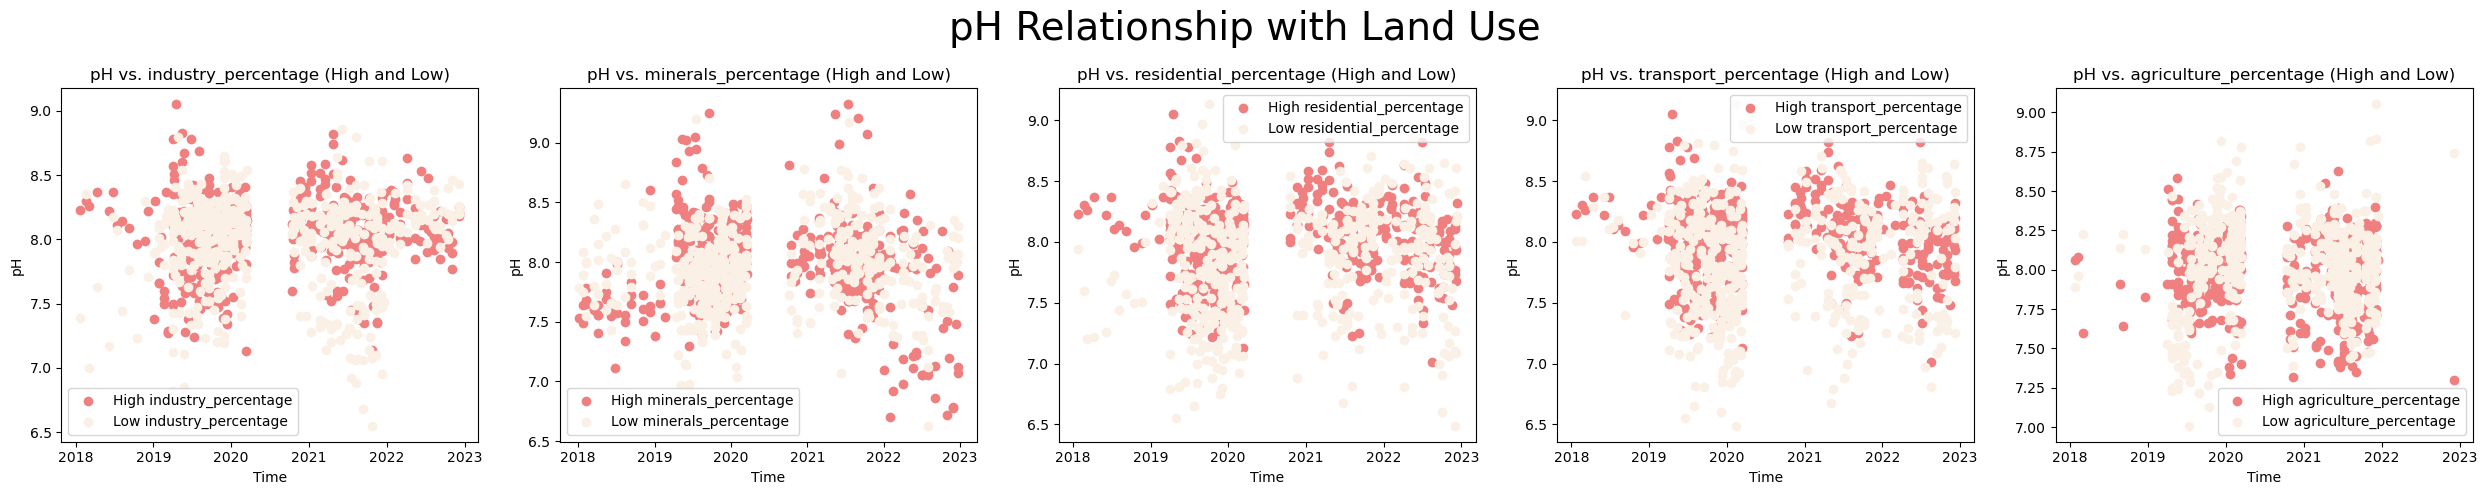

In [94]:
ncols = len(factors) 
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

axes = axes if isinstance(axes, np.ndarray) else [axes]

# loop through the factors to create each subplot
for i, factor in enumerate(factors):
    ax = axes[i]

    ph_high = largest_values[factor]["pH"].values
    ph_low = smallest_values[factor]["pH"].values
    
    time = largest_values[factor]["sample_date_time"].values  
    
    # scatter plot for both high and low values together
    ax.scatter(time, ph_high, color='lightcoral', label='High ' + factor)
    ax.scatter(time, ph_low, color='linen', label='Low ' + factor)

    ax.set_title(f"pH vs. {factor} (High and Low)")
    ax.set_xlabel("Time")
    ax.set_ylabel("pH")
    ax.legend()
fig.suptitle('pH Relationship with Land Use', fontsize=28)
plt.tight_layout()  
plt.show()


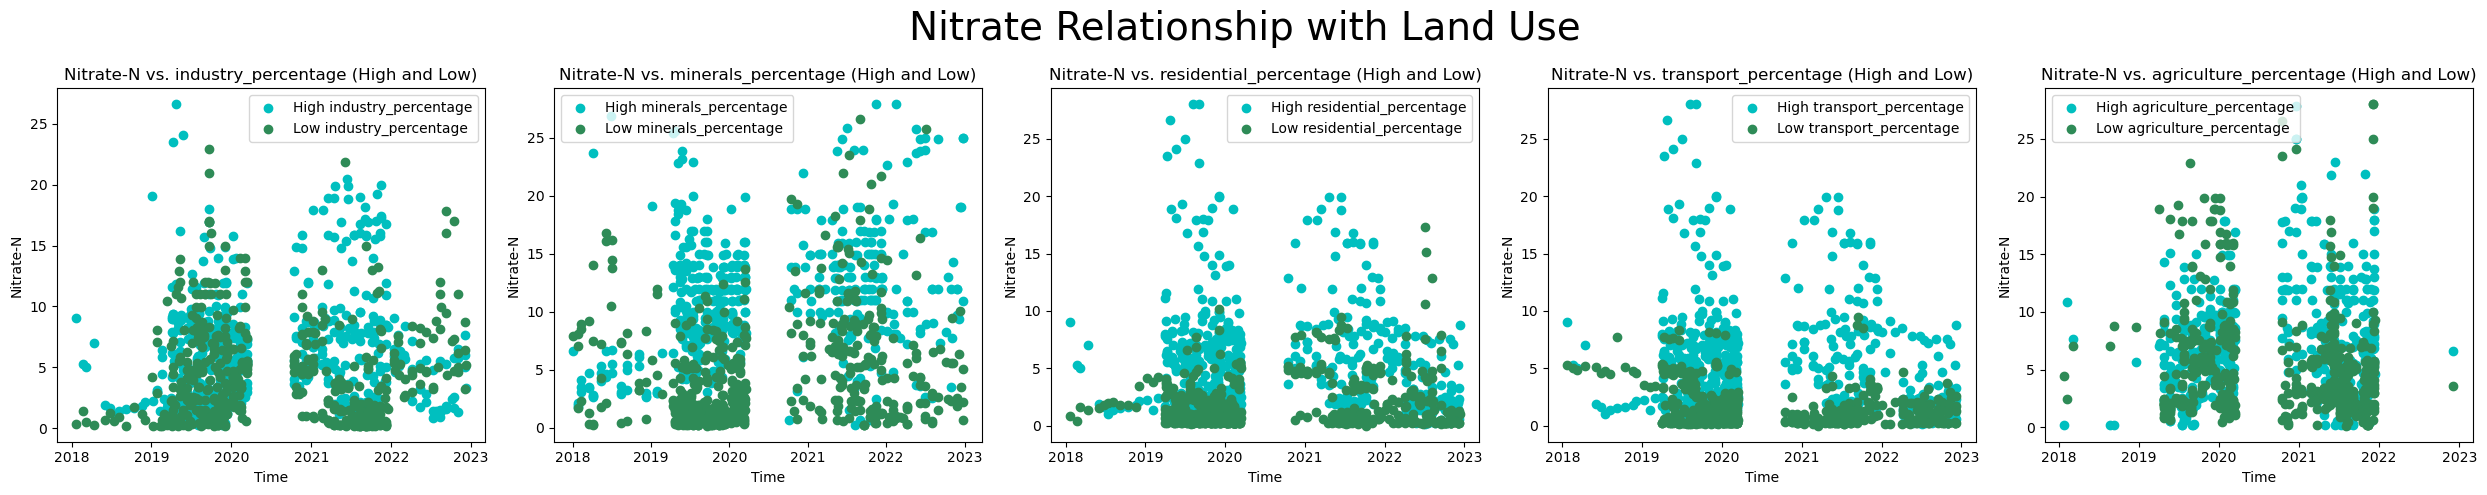

In [95]:
ncols = len(factors)  
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

axes = axes if isinstance(axes, np.ndarray) else [axes]

# loop through the factors to create each subplot
for i, factor in enumerate(factors):
    ax = axes[i]

    nitrate_high = largest_values[factor]["Nitrate-N"].values
    nitrate_low = smallest_values[factor]["Nitrate-N"].values

    time = largest_values[factor]["sample_date_time"].values  
    
    # scatter plot for both high and low values together
    ax.scatter(time, nitrate_high, color='c', label='High ' + factor)
    ax.scatter(time, nitrate_low, color='seagreen', label='Low ' + factor)

    ax.set_title(f"Nitrate-N vs. {factor} (High and Low)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Nitrate-N")
    ax.legend()
fig.suptitle('Nitrate Relationship with Land Use', fontsize=28)
plt.tight_layout() 
plt.show()


In [96]:
gdf_sampling_points = gpd.GeoDataFrame(
    df_ammonia, 
    geometry=gpd.points_from_xy(df_ammonia['northing'], df_ammonia['easting']),
    crs="EPSG:27700" 
)
gdf_sampling_points.head()

Unnamed: 0  compliance    sample_date_time  northing  \
sample_date_time                                                            
2014-01-01 00:02:00     1499904       False 2014-01-01 00:02:00    519048   
2014-01-02 07:48:00      385139       False 2014-01-02 07:48:00    288663   
2014-01-02 07:59:00      648258       False 2014-01-02 07:59:00    343100   
2014-01-02 08:02:00     2373922       False 2014-01-02 08:02:00    208575   
2014-01-02 08:06:00      648155       False 2014-01-02 08:06:00    341994   

                     easting determinand_label           determinand_def  \
sample_date_time                                                           
2014-01-01 00:02:00   359677        Ammonia(N)  Ammoniacal Nitrogen as N   
2014-01-02 07:48:00   632717        Ammonia(N)  Ammoniacal Nitrogen as N   
2014-01-02 07:59:00   461500        Ammonia(N)  Ammoniacal Nitrogen as N   
2014-01-02 08:02:00   435140        Ammonia(N)  Ammoniacal Nitrogen as N   
2014-01-02 08:06:00   462172        Ammonia(N)  Ammoniacal Nitrogen as N   

                     result determinand_unit                    sample_type  \
sample_date_time                                                              
2014-01-01 00:02:00   0.030             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 07:48:00   0.072             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 07:59:00   0.519             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 08:02:00   0.648             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 08:06:00   0.500             mg/l  RIVER / RUNNING SURFACE WATER   

                     year  rolling_avg                   geometry  
sample_date_time                                                   
2014-01-01 00:02:00  2014      0.03000   POINT (5.19e+05 3.6e+05)  
2014-01-02 07:48:00  2014      0.05100  POINT (2.89e+05 6.33e+05)  
2014-01-02 07:59:00  2014      0.20700  POINT (3.43e+05 4.62e+05)  
2014-01-02 08:02:00  2014      0.31725  POINT (2.09e+05 4.35e+05)  
2014-01-02 08:06:00  2014      0.35380  POINT (3.42e+05 4.62e+05)

In [98]:
# convert sampling points into a gdf with Point geometries
gdf_sampling_points['geometry'] = gdf_sampling_points.apply(
    lambda row: Point(row['easting'], row['northing']), axis=1
)

# convert to gdf and set CRS to British National Grid (EPSG:27700)
gdf_sampling_points = gpd.GeoDataFrame(gdf_sampling_points, geometry='geometry', crs="EPSG:27700")
boundaries = boundaries.to_crs("EPSG:27700")  

# perform spatial join to assign each sampling point to a Local Authority
# Reset index before spatial join, avoiding conflict with 'sample_date_time' column
gdf_sampling_points = gdf_sampling_points.reset_index(drop=True)
gdf_classified = gpd.sjoin(gdf_sampling_points, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")

# keep only relevant columns
gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',	'determinand_def',	'result',	'determinand_unit',	'sample_type',	'year']]


In [100]:
# merge land use data with local authority boundaries
merge = boundaries.merge(gdf_classified, left_on="LAD22NM", right_on="LAD22NM")
merge.shape

(445740, 18)

/opt/anaconda3/lib/python3.12/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  warnings.warn(


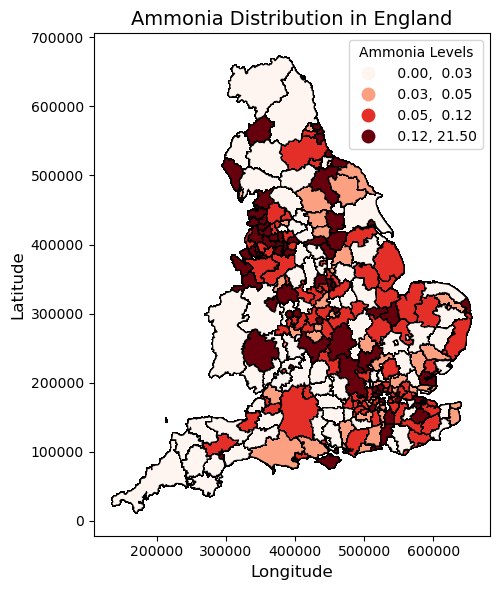

In [102]:
fig, ax = plt.subplots(figsize=(10, 6))

merge.plot(
    column="result",
    cmap="Reds",        
    linewidth=0.8,
    legend=True,            
    scheme="quantiles",   
    ax=ax,
    edgecolor="black"      
)

ax.set_title("Ammonia Distribution in England", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

leg = ax.get_legend()
leg.set_title("Ammonia Levels")
plt.tight_layout()
plt.show()


In [106]:
gdf_sampling_points = gpd.GeoDataFrame(
    df_bod, 
    geometry=gpd.points_from_xy(df_bod['northing'], df_bod['easting']),
    crs="EPSG:27700" 
)
gdf_sampling_points.head()

Unnamed: 0  compliance    sample_date_time  northing  \
sample_date_time                                                            
2014-01-02 07:48:00      385138       False 2014-01-02 07:48:00    288663   
2014-01-02 07:59:00      648256       False 2014-01-02 07:59:00    343100   
2014-01-02 08:06:00      648162       False 2014-01-02 08:06:00    341994   
2014-01-02 08:12:00      647898       False 2014-01-02 08:12:00    341877   
2014-01-02 08:30:00     2374582       False 2014-01-02 08:30:00    208900   

                     easting determinand_label  determinand_def  result  \
sample_date_time                                                          
2014-01-02 07:48:00   632717           BOD ATU  BOD : 5 Day ATU    1.00   
2014-01-02 07:59:00   461500           BOD ATU  BOD : 5 Day ATU    1.66   
2014-01-02 08:06:00   462172           BOD ATU  BOD : 5 Day ATU    1.20   
2014-01-02 08:12:00   462258           BOD ATU  BOD : 5 Day ATU    2.06   
2014-01-02 08:30:00   435383           BOD ATU  BOD : 5 Day ATU    1.00   

                    determinand_unit                    sample_type  year  \
sample_date_time                                                            
2014-01-02 07:48:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 07:59:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:06:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:12:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:30:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   

                     rolling_avg                   geometry  
sample_date_time                                             
2014-01-02 07:48:00     1.000000  POINT (2.89e+05 6.33e+05)  
2014-01-02 07:59:00     1.330000  POINT (3.43e+05 4.62e+05)  
2014-01-02 08:06:00     1.286667  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:12:00     1.480000  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:30:00     1.384000  POINT (2.09e+05 4.35e+05)

In [110]:
# convert sampling points into a gdf with Point geometries
gdf_sampling_points['geometry'] = gdf_sampling_points.apply(
    lambda row: Point(row['easting'], row['northing']), axis=1
)

# convert to gdf and set CRS to British National Grid (EPSG:27700)
gdf_sampling_points = gpd.GeoDataFrame(gdf_sampling_points, geometry='geometry', crs="EPSG:27700")
boundaries = boundaries.to_crs("EPSG:27700")  

# perform spatial join to assign each sampling point to a Local Authority
# Reset index before spatial join, avoiding conflict with 'sample_date_time' column
gdf_sampling_points = gdf_sampling_points.reset_index(drop=True)
gdf_classified = gpd.sjoin(gdf_sampling_points, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")

# keep only relevant columns
gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',	'determinand_def',	'result',	'determinand_unit',	'sample_type',	'year']]


In [112]:
# merge land use data with local authority boundaries
merge = boundaries.merge(gdf_classified, left_on="LAD22NM", right_on="LAD22NM")
merge.shape

(94754, 18)

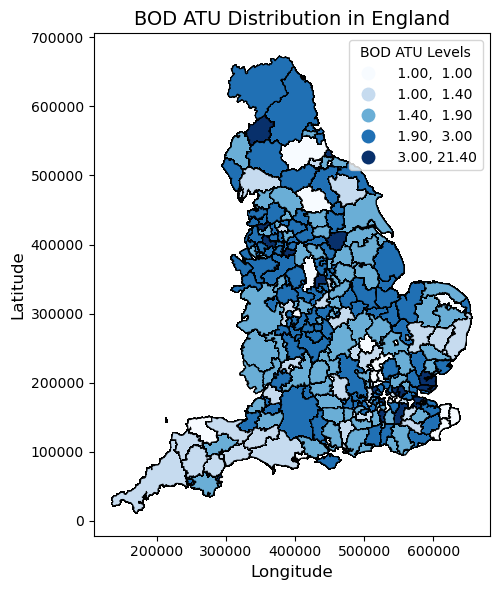

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot bod levels with better clarity and handling
merge.plot(
    column="result",
    cmap="Blues",          # darker green means higher ammonia
    linewidth=0.8,
    legend=True,            
    scheme="quantiles",     # categorise using quantiles
    ax=ax,
    edgecolor="black"       # add clear region borders
)

ax.set_title("BOD ATU Distribution in England", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

leg = ax.get_legend()
leg.set_title("BOD ATU Levels")

plt.tight_layout()
plt.show()


In [116]:
gdf_sampling_points = gpd.GeoDataFrame(
    df_ss, 
    geometry=gpd.points_from_xy(df_ss['northing'], df_ss['easting']),
    crs="EPSG:27700" 
)
gdf_sampling_points.head()

Unnamed: 0  compliance    sample_date_time  northing  \
sample_date_time                                                            
2014-01-01 00:02:00     1499905       False 2014-01-01 00:02:00    519048   
2014-01-02 07:48:00      385143       False 2014-01-02 07:48:00    288663   
2014-01-02 08:02:00     2373928       False 2014-01-02 08:02:00    208575   
2014-01-02 08:06:00      648161       False 2014-01-02 08:06:00    341994   
2014-01-02 08:12:00      647902       False 2014-01-02 08:12:00    341877   

                     easting determinand_label             determinand_def  \
sample_date_time                                                             
2014-01-01 00:02:00   359677      Sld Sus@105C  Solids, Suspended at 105 C   
2014-01-02 07:48:00   632717      Sld Sus@105C  Solids, Suspended at 105 C   
2014-01-02 08:02:00   435140      Sld Sus@105C  Solids, Suspended at 105 C   
2014-01-02 08:06:00   462172      Sld Sus@105C  Solids, Suspended at 105 C   
2014-01-02 08:12:00   462258      Sld Sus@105C  Solids, Suspended at 105 C   

                     result determinand_unit                    sample_type  \
sample_date_time                                                              
2014-01-01 00:02:00    6.17             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 07:48:00   18.10             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 08:02:00    8.63             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 08:06:00   12.70             mg/l  RIVER / RUNNING SURFACE WATER   
2014-01-02 08:12:00   12.60             mg/l  RIVER / RUNNING SURFACE WATER   

                     year  rolling_avg                   geometry  
sample_date_time                                                   
2014-01-01 00:02:00  2014     6.170000   POINT (5.19e+05 3.6e+05)  
2014-01-02 07:48:00  2014    12.135000  POINT (2.89e+05 6.33e+05)  
2014-01-02 08:02:00  2014    10.966667  POINT (2.09e+05 4.35e+05)  
2014-01-02 08:06:00  2014    11.400000  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:12:00  2014    11.640000  POINT (3.42e+05 4.62e+05)

In [118]:
# convert sampling points into a gdf with Point geometries
gdf_sampling_points['geometry'] = gdf_sampling_points.apply(
    lambda row: Point(row['easting'], row['northing']), axis=1
)

# convert to gdf and set CRS to British National Grid (EPSG:27700)
gdf_sampling_points = gpd.GeoDataFrame(gdf_sampling_points, geometry='geometry', crs="EPSG:27700")
boundaries = boundaries.to_crs("EPSG:27700")  

# perform spatial join to assign each sampling point to a Local Authority
# Reset index before spatial join, avoiding conflict with 'sample_date_time' column
gdf_sampling_points = gdf_sampling_points.reset_index(drop=True)
gdf_classified = gpd.sjoin(gdf_sampling_points, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")

# keep only relevant columns
gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',	'determinand_def',	'result',	'determinand_unit',	'sample_type',	'year']]


In [120]:
# merge land use data with local authority boundaries
merge = boundaries.merge(gdf_classified, left_on="LAD22NM", right_on="LAD22NM")
merge.shape

(167422, 18)

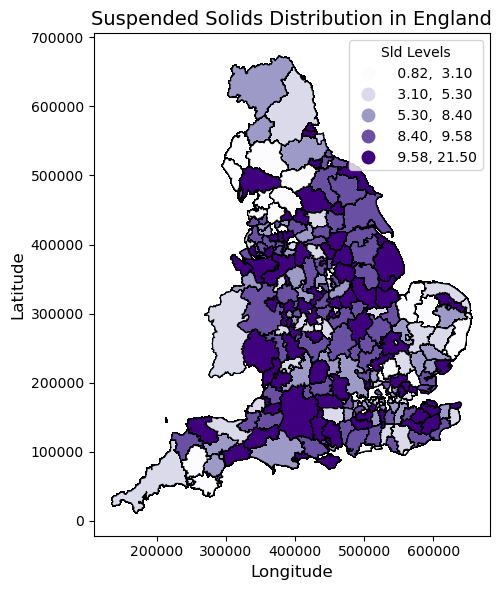

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot solids levels with better clarity and handling
merge.plot(
    column="result",
    cmap="Purples",       
    linewidth=0.8,
    legend=True,           
    scheme="quantiles",    
    ax=ax,
    edgecolor="black"  
)

ax.set_title("Suspended Solids Distribution in England", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

leg = ax.get_legend()
leg.set_title("Sld Levels")

plt.tight_layout()
plt.show()

In [123]:
gdf_sampling_points = gpd.GeoDataFrame(
    df_nitrate, 
    geometry=gpd.points_from_xy(df_nitrate['northing'], df_nitrate['easting']),
    crs="EPSG:27700" 
)
gdf_sampling_points.head()

Unnamed: 0  compliance    sample_date_time  northing  \
sample_date_time                                                            
2014-01-01 00:02:00     1499902       False 2014-01-01 00:02:00    519048   
2014-01-02 07:48:00      385131       False 2014-01-02 07:48:00    288663   
2014-01-02 08:02:00     2373929       False 2014-01-02 08:02:00    208575   
2014-01-02 08:06:00      648158       False 2014-01-02 08:06:00    341994   
2014-01-02 08:12:00     1013809       False 2014-01-02 08:12:00    516465   

                     easting determinand_label determinand_def  result  \
sample_date_time                                                         
2014-01-01 00:02:00   359677         Nitrate-N    Nitrate as N    1.59   
2014-01-02 07:48:00   632717         Nitrate-N    Nitrate as N   12.40   
2014-01-02 08:02:00   435140         Nitrate-N    Nitrate as N    7.22   
2014-01-02 08:06:00   462172         Nitrate-N    Nitrate as N    4.57   
2014-01-02 08:12:00   431650         Nitrate-N    Nitrate as N    4.69   

                    determinand_unit                    sample_type  year  \
sample_date_time                                                            
2014-01-01 00:02:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 07:48:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:02:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:06:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:12:00             mg/l  RIVER / RUNNING SURFACE WATER  2014   

                     rolling_avg                   geometry  
sample_date_time                                             
2014-01-01 00:02:00        1.590   POINT (5.19e+05 3.6e+05)  
2014-01-02 07:48:00        6.995  POINT (2.89e+05 6.33e+05)  
2014-01-02 08:02:00        7.070  POINT (2.09e+05 4.35e+05)  
2014-01-02 08:06:00        6.445  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:12:00        6.094  POINT (5.16e+05 4.32e+05)

In [126]:
# convert sampling points into a gdf with Point geometries
gdf_sampling_points['geometry'] = gdf_sampling_points.apply(
    lambda row: Point(row['easting'], row['northing']), axis=1
)

# convert to gdf and set CRS to British National Grid (EPSG:27700)
gdf_sampling_points = gpd.GeoDataFrame(gdf_sampling_points, geometry='geometry', crs="EPSG:27700")
boundaries = boundaries.to_crs("EPSG:27700")  

# perform spatial join to assign each sampling point to a Local Authority
# Reset index before spatial join, avoiding conflict with 'sample_date_time' column
gdf_sampling_points = gdf_sampling_points.reset_index(drop=True)
gdf_classified = gpd.sjoin(gdf_sampling_points, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")

# keep only relevant columns
gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',	'determinand_def',	'result',	'determinand_unit',	'sample_type',	'year']]


In [128]:
# merge land use data with local authority boundaries
merge = boundaries.merge(gdf_classified, left_on="LAD22NM", right_on="LAD22NM")
merge.shape

(428187, 18)

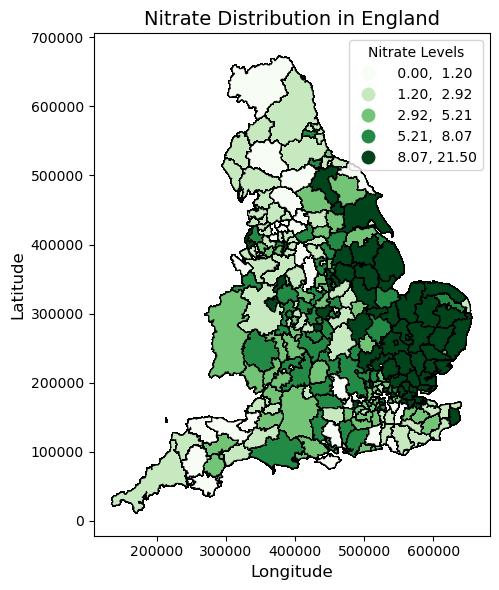

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))

merge.plot(
    column="result",
    cmap="Greens",        
    linewidth=0.8,
    legend=True,           
    scheme="quantiles",   
    ax=ax,
    edgecolor="black"      
)

ax.set_title("Nitrate Distribution in England", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

leg = ax.get_legend()
leg.set_title("Nitrate Levels")

plt.tight_layout()
plt.show()

In [132]:
gdf_sampling_points = gpd.GeoDataFrame(
    df_ph, 
    geometry=gpd.points_from_xy(df_ph['northing'], df_ph['easting']),
    crs="EPSG:27700" 
)
gdf_sampling_points.head()

Unnamed: 0  compliance    sample_date_time  northing  \
sample_date_time                                                            
2014-01-02 07:48:00      385146       False 2014-01-02 07:48:00    288663   
2014-01-02 08:02:00     2373924       False 2014-01-02 08:02:00    208575   
2014-01-02 08:06:00      648156       False 2014-01-02 08:06:00    341994   
2014-01-02 08:12:00      647900       False 2014-01-02 08:12:00    341877   
2014-01-02 08:12:00     1013812       False 2014-01-02 08:12:00    516465   

                     easting determinand_label determinand_def  result  \
sample_date_time                                                         
2014-01-02 07:48:00   632717                pH              pH    8.02   
2014-01-02 08:02:00   435140                pH              pH    7.47   
2014-01-02 08:06:00   462172                pH              pH    8.03   
2014-01-02 08:12:00   462258                pH              pH    7.81   
2014-01-02 08:12:00   431650                pH              pH    8.00   

                    determinand_unit                    sample_type  year  \
sample_date_time                                                            
2014-01-02 07:48:00          phunits  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:02:00          phunits  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:06:00          phunits  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:12:00          phunits  RIVER / RUNNING SURFACE WATER  2014   
2014-01-02 08:12:00          phunits  RIVER / RUNNING SURFACE WATER  2014   

                     rolling_avg                   geometry  
sample_date_time                                             
2014-01-02 07:48:00       8.0200  POINT (2.89e+05 6.33e+05)  
2014-01-02 08:02:00       7.7450  POINT (2.09e+05 4.35e+05)  
2014-01-02 08:06:00       7.8400  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:12:00       7.8325  POINT (3.42e+05 4.62e+05)  
2014-01-02 08:12:00       7.8660  POINT (5.16e+05 4.32e+05)

In [134]:
# convert sampling points into a gdf with Point geometries
gdf_sampling_points['geometry'] = gdf_sampling_points.apply(
    lambda row: Point(row['easting'], row['northing']), axis=1
)

# convert to gdf and set CRS to British National Grid (EPSG:27700)
gdf_sampling_points = gpd.GeoDataFrame(gdf_sampling_points, geometry='geometry', crs="EPSG:27700")
boundaries = boundaries.to_crs("EPSG:27700")  

# perform spatial join to assign each sampling point to a Local Authority
# Reset index before spatial join, avoiding conflict with 'sample_date_time' column
gdf_sampling_points = gdf_sampling_points.reset_index(drop=True)
gdf_classified = gpd.sjoin(gdf_sampling_points, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")

# keep only relevant columns
gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',	'determinand_def',	'result',	'determinand_unit',	'sample_type',	'year']]


In [136]:
# merge land use data with local authority boundaries
merge = boundaries.merge(gdf_classified, left_on="LAD22NM", right_on="LAD22NM")
merge.shape

(440065, 18)

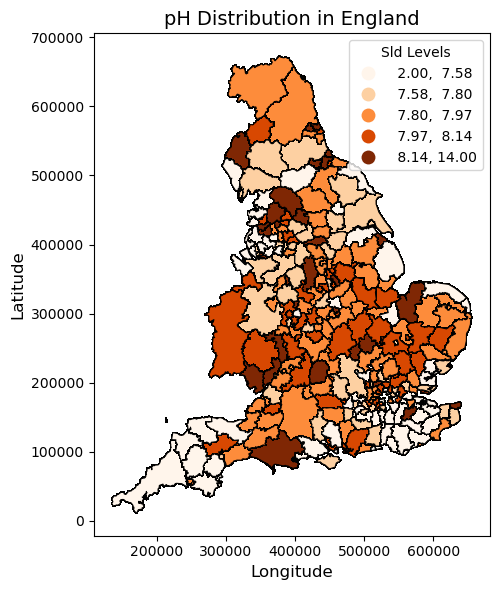

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))

merge.plot(
    column="result",
    cmap="Oranges",         
    linewidth=0.8,
    legend=True,        
    scheme="quantiles",    
    ax=ax,
    edgecolor="black"    
)

ax.set_title("pH Distribution in England", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

leg = ax.get_legend()
leg.set_title("Sld Levels")

plt.tight_layout()
plt.show()

In [140]:
#handle object dtypes that are supposed to be numeric
columns= ['industry_and_commerce_total', 'landfill_and_waste_disposal', 'minerals_and_mining', 'minerals_and_landfill_total', 'residential', 'residential_total', 'highways_and_road_transport', 'transport_other', 'utilities', 'transport_and_utilities_total', 'agricultural_buildings', 'agricultural_land', 'agriculture_total', 'grand_total'] 
for column in columns:
    landuse[column] = landuse[column].astype(str).str.strip()
    landuse[column] = landuse[column].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    landuse[column] = pd.to_numeric(landuse[column])

In [142]:
landuse.head()

local_authority_name  industry  offices  retail  storage_and_warehousing  \
0                 Adur      12.0      4.0    10.0                      8.0   
1            Allerdale      73.0      9.0    26.0                     27.0   
2         Amber Valley      23.0      8.0    64.0                     53.0   
3                 Arun      27.0      6.0    30.0                     20.0   
4             Ashfield     103.0     10.0    24.0                     52.0   

   industry_and_commerce_total  landfill_and_waste_disposal  \
0                         34.0                          1.0   
1                        135.0                          0.0   
2                        148.0                          0.0   
3                         83.0                          1.0   
4                        189.0                         13.0   

   minerals_and_mining  minerals_and_landfill_total  \
0                  NaN                          1.0   
1                  1.0                          1.0   
2                  NaN                          0.0   
3                 19.0                         19.0   
4                  0.0                         13.0   

   institutional_and_communal_accommodations  ...  residential_total  \
0                                        1.0  ...              190.0   
1                                       19.0  ...              411.0   
2                                       10.0  ...              424.0   
3                                       15.0  ...              584.0   
4                                        9.0  ...              372.0   

   highways_and_road_transport  transport_other  utilities  \
0                        308.0            149.0        7.0   
1                       2617.0            299.0       71.0   
2                       1013.0            114.0       17.0   
3                       1165.0             80.0       87.0   
4                        729.0             40.0       47.0   

   transport_and_utilities_total  agricultural_buildings  agricultural_land  \
0                          465.0                     3.0             2129.0   
1                         2988.0                    38.0            69418.0   
2                         1144.0                    15.0            17644.0   
3                         1333.0                    27.0            12164.0   
4                          816.0                    13.0             4676.0   

   agriculture_total  grand_total  year  
0             2131.0       4207.0  2022  
1            69456.0     125831.0  2022  
2            17660.0      26544.0  2022  
3            12191.0      22099.0  2022  
4             4689.0      10956.0  2022  

[5 rows x 21 columns]

In [144]:
landuse = landuse.drop([
              'offices', 
              'retail',
              'industry_and_commerce_total',
              'landfill_and_waste_disposal', 
              'minerals_and_landfill_total',
              'institutional_and_communal_accommodations',
              'residential',
              'utilities', 
              'transport_and_utilities_total', 
              'agricultural_buildings',
              'agricultural_land'], axis = 1)

In [146]:
landuse['minerals_and_mining'].fillna(0, inplace=True)

/var/folders/jp/lg_9lz6n3pl67xbgkk8bw9qh0000gn/T/ipykernel_52729/1020587139.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  landuse['minerals_and_mining'].fillna(0, inplace=True)


In [148]:
landuse.dropna(inplace=True)


In [150]:
print(landuse.isnull().sum())

local_authority_name           0
industry                       0
storage_and_warehousing        0
minerals_and_mining            0
residential_total              0
highways_and_road_transport    0
transport_other                0
agriculture_total              0
grand_total                    0
year                           0
dtype: int64


In [152]:
# normalise factor columns
landuse['industry_total'] = landuse['industry'] + landuse['storage_and_warehousing']
landuse['transport_total'] = landuse['highways_and_road_transport'] + landuse['transport_other']

landuse['industry_percentage'] = (landuse['industry_total'] / landuse['grand_total']) * 100
landuse['minerals_percentage'] = (landuse['minerals_and_mining'] / landuse['grand_total']) * 100
landuse['residential_percentage'] = (landuse['residential_total'] / landuse['grand_total']) * 100
landuse['transport_percentage'] = (landuse['transport_total'] / landuse['grand_total']) * 100
landuse['agriculture_percentage'] = (landuse['agriculture_total'] / landuse['grand_total']) * 100


In [153]:
landuse = landuse.drop(['industry','storage_and_warehousing', 'minerals_and_mining', 'residential_total',
       'highways_and_road_transport', 'transport_other', 'agriculture_total',
       'grand_total', 'industry_total', 'transport_total'], axis = 1)

In [156]:
# merge land use data with local authority boundaries
land_and_local = boundaries.merge(landuse, left_on="LAD22NM", right_on="local_authority_name")

# check the merged data
print(land_and_local.head())

   FID    LAD22CD     LAD22NM   BNG_E   BNG_N     LONG       LAT  \
0    1  E06000001  Hartlepool  447160  531474 -1.27018  54.67614   
1    1  E06000001  Hartlepool  447160  531474 -1.27018  54.67614   
2    1  E06000001  Hartlepool  447160  531474 -1.27018  54.67614   
3    1  E06000001  Hartlepool  447160  531474 -1.27018  54.67614   
4    1  E06000001  Hartlepool  447160  531474 -1.27018  54.67614   

                               GlobalID  \
0  0c2caf9e-a186-4be5-81a1-ff4fcc433ee5   
1  0c2caf9e-a186-4be5-81a1-ff4fcc433ee5   
2  0c2caf9e-a186-4be5-81a1-ff4fcc433ee5   
3  0c2caf9e-a186-4be5-81a1-ff4fcc433ee5   
4  0c2caf9e-a186-4be5-81a1-ff4fcc433ee5   

                                            geometry local_authority_name  \
0  POLYGON ((4.49e+05 5.37e+05, 4.49e+05 5.37e+05...           Hartlepool   
1  POLYGON ((4.49e+05 5.37e+05, 4.49e+05 5.37e+05...           Hartlepool   
2  POLYGON ((4.49e+05 5.37e+05, 4.49e+05 5.37e+05...           Hartlepool   
3  POLYGON ((4.49e+05 5.

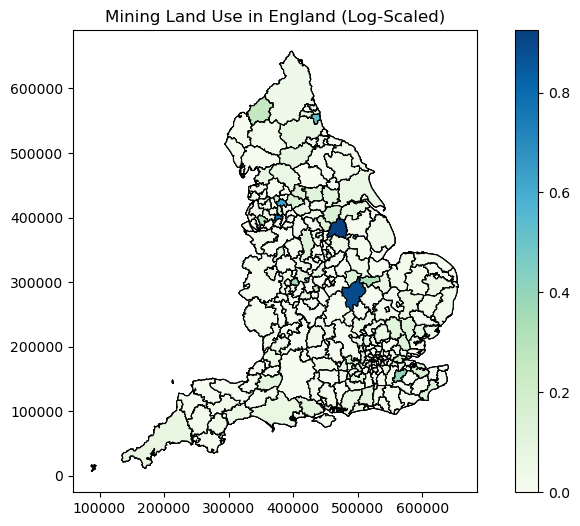

In [158]:
# apply log transformation (adding a small constant to avoid log(0))
land_and_local['minerals_percentage_log'] = np.log1p(land_and_local['minerals_percentage'])

# plot the log-transformed column with a legend
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot = land_and_local.plot(column="minerals_percentage_log", cmap="GnBu", linewidth=0.8, edgecolor="black", ax=ax, legend=True)
leg = plot.get_legend()

plt.title("Mining Land Use in England (Log-Scaled)")
plt.show()


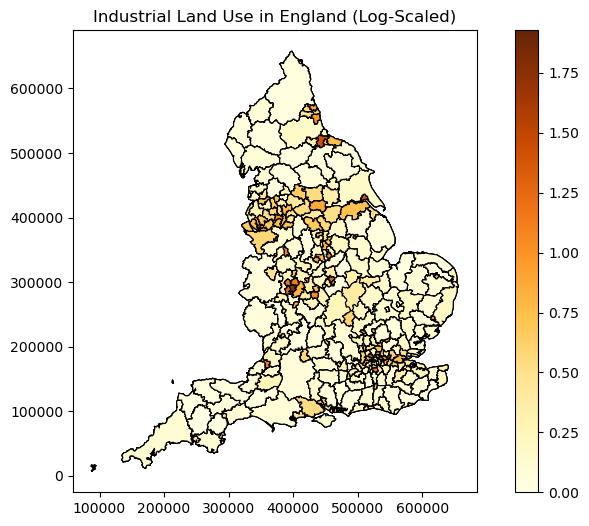

In [160]:
land_and_local['industry_percentage_log'] = np.log1p(land_and_local['industry_percentage'])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot = land_and_local.plot(column="industry_percentage_log", cmap="YlOrBr", linewidth=0.8, edgecolor="black", ax=ax, legend=True)

leg = plot.get_legend()

plt.title("Industrial Land Use in England (Log-Scaled)")

plt.show()


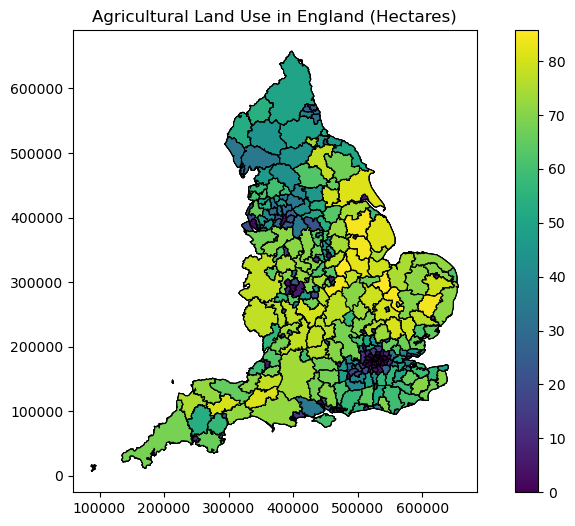

In [161]:
# plot agricultural land use with a legend
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot = land_and_local.plot(column="agriculture_percentage", cmap="viridis", linewidth=0.8, edgecolor="black", ax=ax, legend=True)
leg = plot.get_legend()
plt.title("Agricultural Land Use in England (Hectares)")

plt.show()


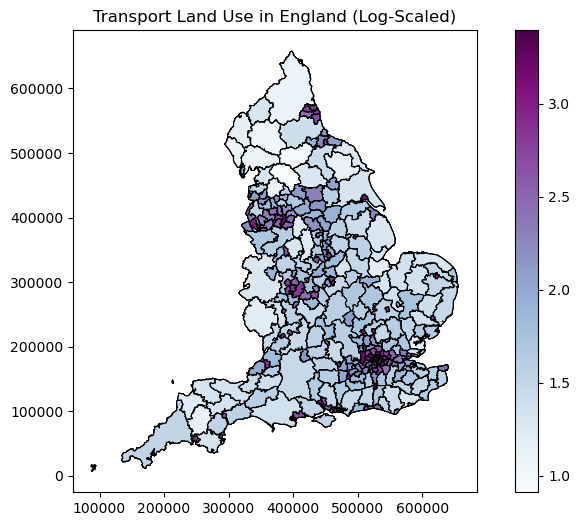

In [164]:
land_and_local['transport_percentage_log'] = np.log1p(land_and_local['transport_percentage'])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot = land_and_local.plot(column="transport_percentage_log", cmap="BuPu", linewidth=0.8, edgecolor="black", ax=ax, legend=True)
leg = plot.get_legend()
plt.title("Transport Land Use in England (Log-Scaled)")
plt.show()


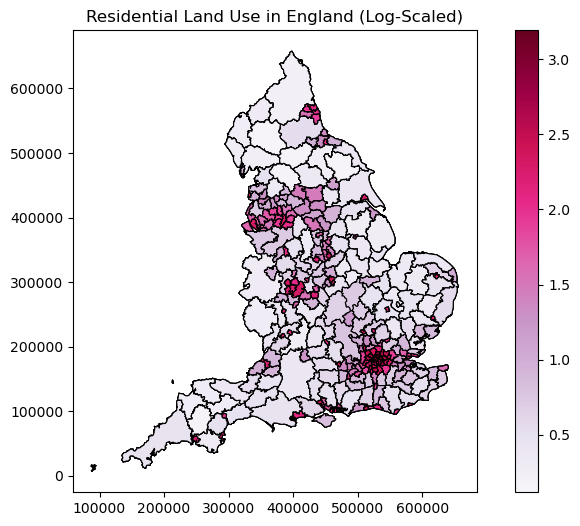

In [165]:
land_and_local['residential_percentage_log'] = np.log1p(land_and_local['residential_percentage'])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot = land_and_local.plot(column="residential_percentage_log", cmap="PuRd", linewidth=0.8, edgecolor="black", ax=ax, legend=True)
leg = plot.get_legend()
plt.title("Residential Land Use in England (Log-Scaled)")
plt.show()


In [168]:
# convert 'sample_date_time' column to datetime dtype
water['sample_date_time'] = pd.to_datetime(water['sample_date_time'], errors='coerce')



In [169]:
# list of parameters to filter
parameters = ['Ammonia(N)', 'BOD ATU', 'Sld Sus@105C', 'Nitrate-N', 'pH']

# dictionary to store dfs for each parameter
param_dfs = {param: water[water["determinand_label"] == param].copy() for param in parameters}

In [172]:
# function to identify outliers using the 0.1 and 0.9 percentiles
def find_outliers(df):
    # select numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # calculate Q1, Q3, and IQR for the specific parameter DataFrame
    Q1 = df[numeric_cols].quantile(0.1)  # 10th percentile
    Q3 = df[numeric_cols].quantile(0.9)  # 90th percentile
    IQR = Q3 - Q1                        # Iinterquartile range
    
    # define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # identify rows where any numeric column is outside the bounds
    mask = (df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)
    
    # return rows that are outliers
    return df[mask.any(axis=1)].copy()

# create a new dictionary to store outlier df for each parameter
outlier_dfs = {param: find_outliers(param_dfs[param]) for param in parameters}

# display the outlier df
for param, outlier_df in outlier_dfs.items():
    print(f"Outliers for {param}:")
    print(outlier_df.head(), "\n")


Outliers for Ammonia(N):
      Unnamed: 0  compliance    sample_date_time  northing  easting  \
918         3942       False 2014-02-12 13:45:00    243799   458736   
965         4103       False 2014-03-18 12:34:00    247101   468153   
981         4159       False 2014-07-11 11:20:00    247101   468153   
1302        6123       False 2014-11-07 10:48:00    225000   491700   
1417        6739       False 2014-05-19 10:33:00    240459   489163   

     determinand_label           determinand_def  result determinand_unit  \
918         Ammonia(N)  Ammoniacal Nitrogen as N   3.280             mg/l   
965         Ammonia(N)  Ammoniacal Nitrogen as N   2.160             mg/l   
981         Ammonia(N)  Ammoniacal Nitrogen as N   2.360             mg/l   
1302        Ammonia(N)  Ammoniacal Nitrogen as N   1.770             mg/l   
1417        Ammonia(N)  Ammoniacal Nitrogen as N   0.899             mg/l   

                        sample_type  year  
918   RIVER / RUNNING SURFACE WATER  2014

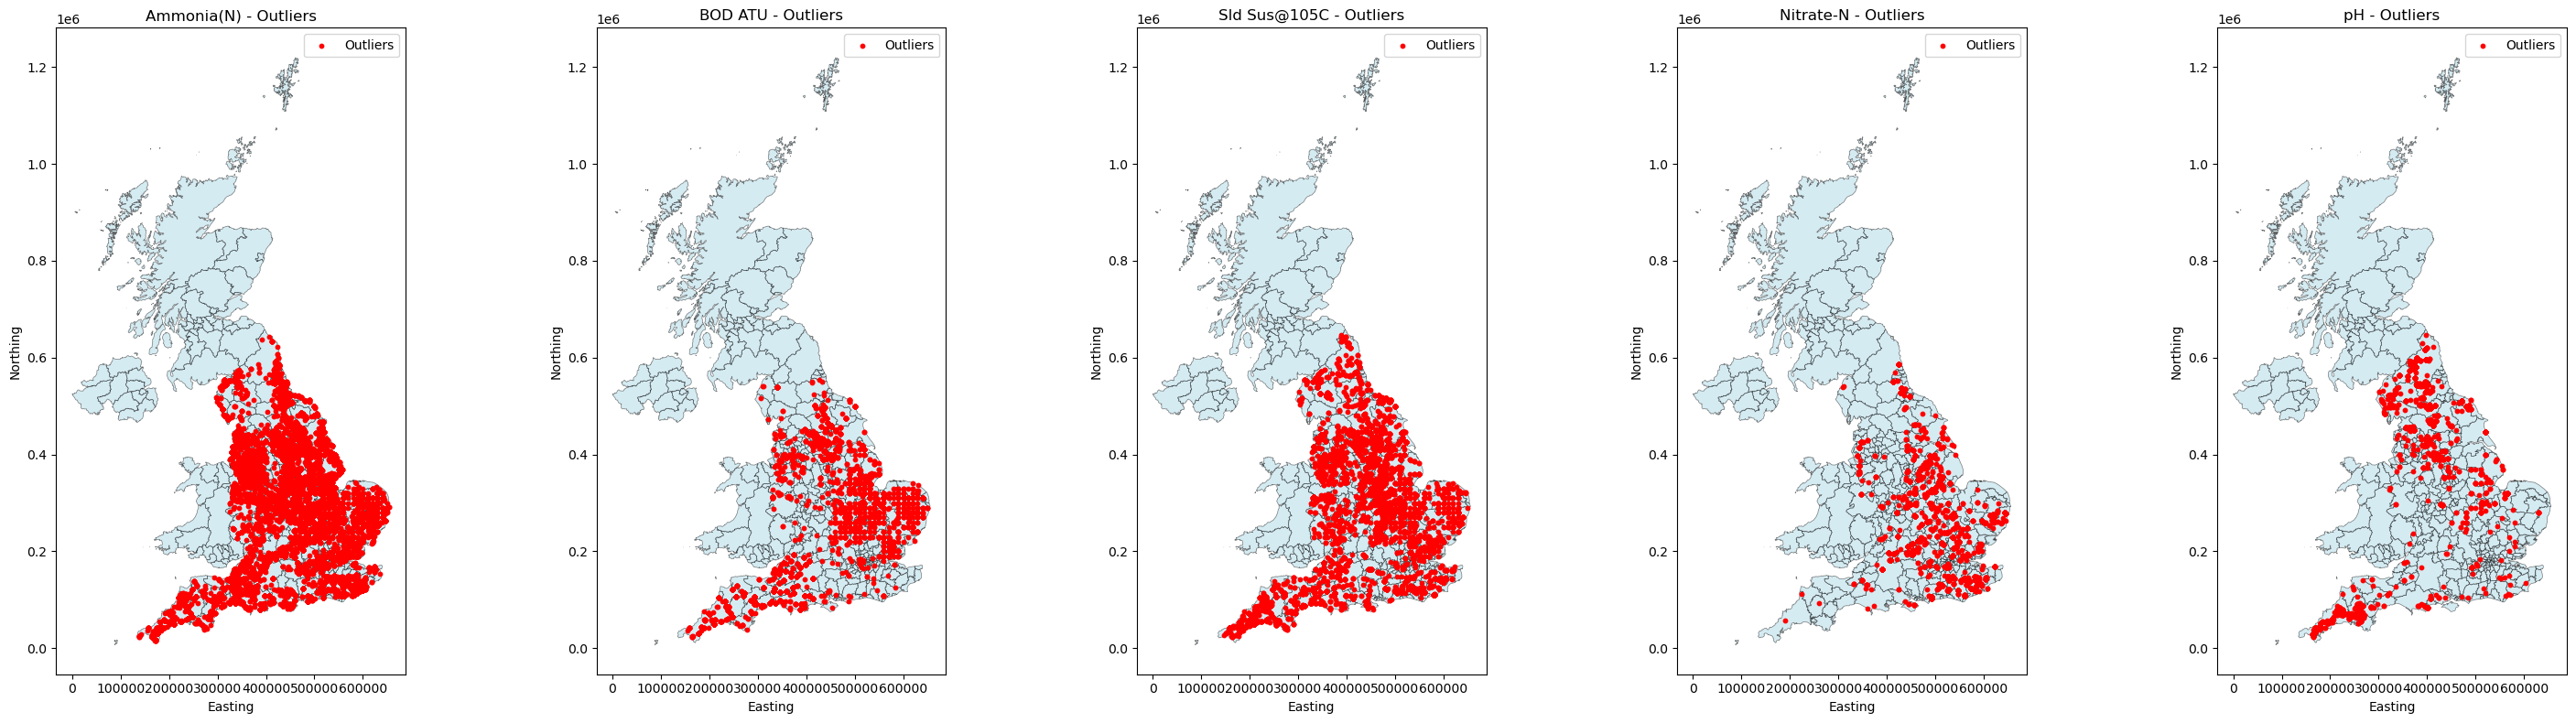

In [174]:
# create GeoDataFrames for each parameter's outliers
gdf_outliers = {}
 
for param in parameters:
    outliers = outlier_dfs[param]
    # create a GeoDataFrame using 'northing' and 'easting'
    gdf = gpd.GeoDataFrame(
        outliers,
        geometry=gpd.points_from_xy(outliers['easting'], outliers['northing']),
        crs="EPSG:27700"  
    )
    # add the GeoDataFrame to the dictionary
    gdf_outliers[param] = gdf
 
# load the boundaries shapefile 
boundaries = boundaries.to_crs("EPSG:27700") 
 
# perform spatial join between outliers and local authority boundaries
gdf_classified_outliers = {}
 
for param in parameters:
    gdf = gdf_outliers[param]
    # perform spatial join to classify each outlier by local authority
    gdf_classified = gpd.sjoin(gdf, boundaries[['LAD22NM', 'geometry']], how="left", predicate="within")
    # keep relevant columns
    gdf_classified = gdf_classified[['sample_date_time', 'northing', 'easting', 'LAD22NM', 'determinand_label',
                                     'determinand_def', 'result', 'determinand_unit', 'sample_type', 'year']]
    # store classified outliers
    gdf_classified_outliers[param] = gdf_classified
 
# merge with local authority boundaries
merged_outliers = {}
 
for param in parameters:
    gdf = gdf_classified_outliers[param]
    # merge outliers GeoDataFrame with boundaries on 'LAD22NM'
    merge = boundaries.merge(gdf, left_on="LAD22NM", right_on="LAD22NM")
    # store merged data
    merged_outliers[param] = merge
 
# plot the distribution of the outliers across England for each parameter
num_params = len(parameters)

fig, axes = plt.subplots(1, num_params, figsize=(6 * num_params, 8))  
 
if num_params == 1:
    axes = [axes]
 
# loop through parameters and plot on corresponding subplot
for i, param in enumerate(parameters):
    ax = axes[i]
    # plot boundaries
    boundaries.plot(ax=ax, edgecolor="black", linewidth=0.5, color='lightblue', alpha=0.5)
    # plot outlier points
    outlier_points = merged_outliers[param]
    ax.scatter(outlier_points['easting'], outlier_points['northing'], color='red', marker='o', s=10, label='Outliers')
    ax.set_title(f"{param} - Outliers")
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.legend()
 
plt.tight_layout()
plt.show()

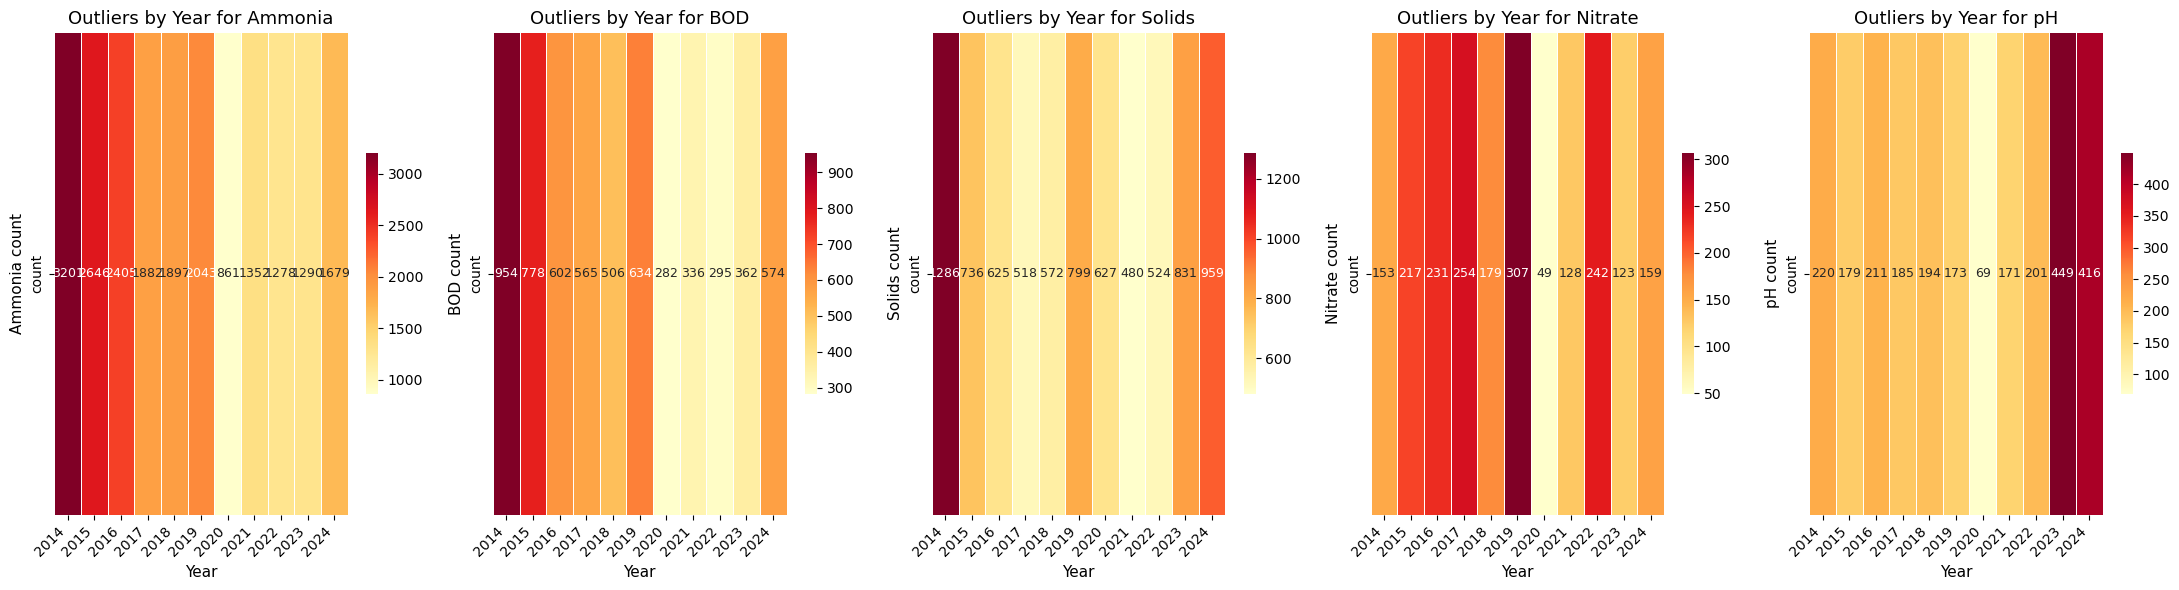

In [176]:
# ensure datetime and extract years explicitly
for param, outlier_df in outlier_dfs.items():
    outlier_df['sample_date_time'] = pd.to_datetime(outlier_df['sample_date_time'], errors='coerce')
    outlier_df['year'] = outlier_df['sample_date_time'].dt.year
 
# list of labels for plotting 
labels = ['Ammonia', 'BOD', 'Solids', 'Nitrate', 'pH']
 
# setup figure 
fig, axes = plt.subplots(1, len(outlier_dfs), figsize=(22, 6))
 
# generate heatmaps clearly
for idx, (param, label) in enumerate(zip(outlier_dfs.keys(), labels)):
    df = outlier_dfs[param]
 
    # count occurrences per year 
    df_counts = df.groupby('year').size().reset_index(name='count').sort_values(by='year')
 
    # create pivot structure suitable for heatmap
    df_pivot = df_counts.set_index('year').T
 
    # plot heatmap clearly with readable font sizes
    sns.heatmap(df_pivot, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=0.5, ax=axes[idx],
                annot_kws={"size": 9}, cbar_kws={'shrink': 0.5})
 
    axes[idx].set_title(f'Outliers by Year for {label}', fontsize=13)
    axes[idx].set_xlabel('Year', fontsize=11)
    axes[idx].set_ylabel(f'{label} count', fontsize=11)
    axes[idx].set_xticklabels(df_pivot.columns, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [178]:
# iterate through the outlier_dfs dictionary to print the shape of each DataFrame
for param, outlier_df in outlier_dfs.items():
    print(f"Shape of outlier DataFrame for {param}: {outlier_df.shape}")


Shape of outlier DataFrame for Ammonia(N): (20534, 11)
Shape of outlier DataFrame for BOD ATU: (5888, 11)
Shape of outlier DataFrame for Sld Sus@105C: (7957, 11)
Shape of outlier DataFrame for Nitrate-N: (2042, 11)
Shape of outlier DataFrame for pH: (2468, 11)


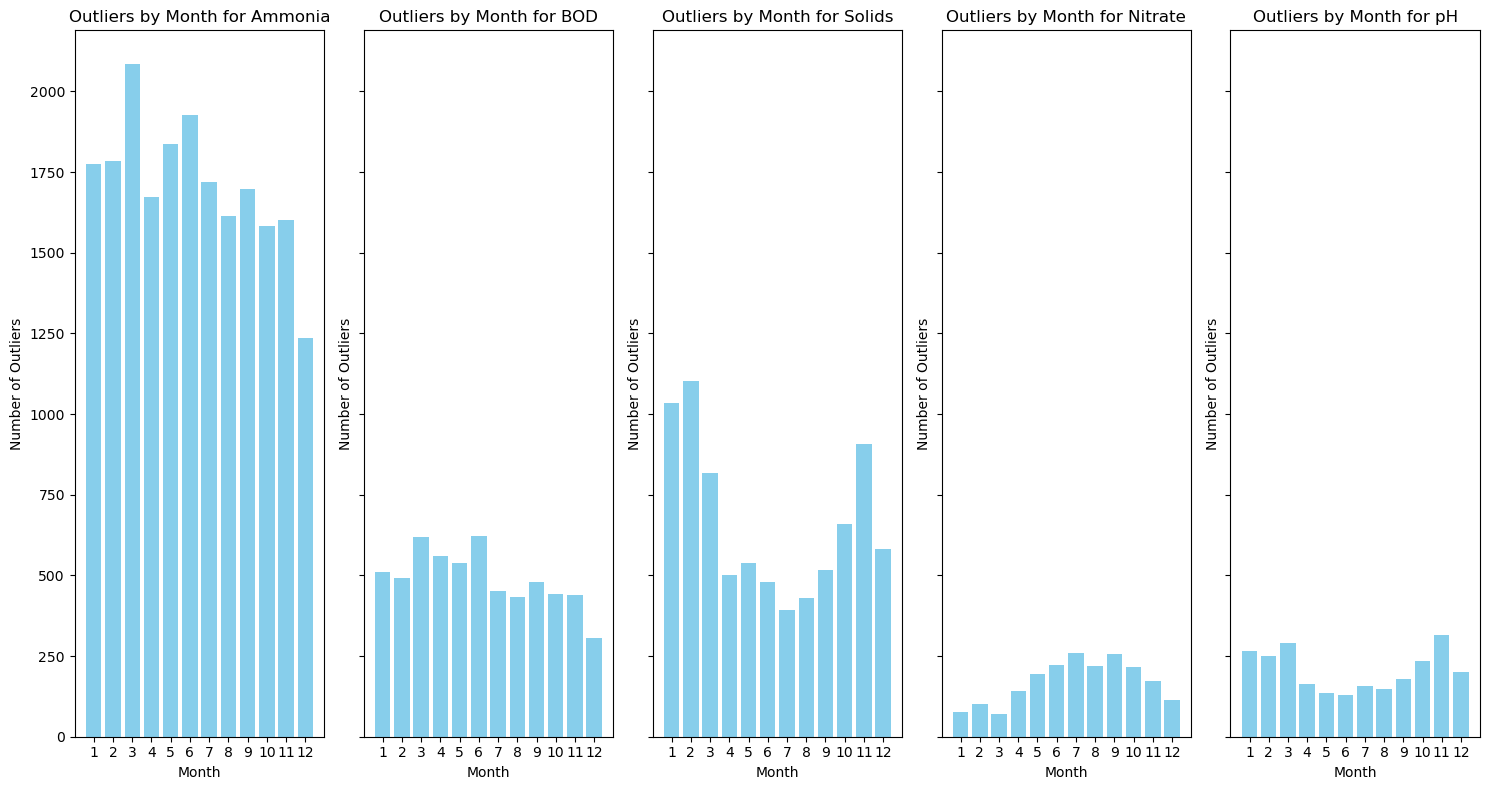

In [180]:
num_plots = len(outlier_dfs)

fig, axes = plt.subplots(1, num_plots, figsize=(15, 8), sharey=True)

# loop through each df, label, and axis to plot
for idx, (param, label) in enumerate(zip(outlier_dfs.keys(), labels)):
    df = outlier_dfs[param]

    df['month'] = df['sample_date_time'].dt.month
    
    # group by month and count occurrences of outliers
    monthly_counts = df.groupby('month').size()

    # plotting bar chart on the corresponding subplot
    axes[idx].bar(monthly_counts.index, monthly_counts, color='skyblue', width=0.8)

    axes[idx].set_title(f'Outliers by Month for {label}')
    axes[idx].set_ylabel('Number of Outliers')
    axes[idx].set_xlabel('Month')
    axes[idx].set_xticks(monthly_counts.index)
    axes[idx].set_xticklabels(monthly_counts.index, rotation=0)

# adjust layout for better spacing
plt.tight_layout()

# show the plot
plt.show()


In [182]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kruskal

def adf_test(series, alpha=0.05):
    """Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    return result[1] < alpha  # Return boolean for stationarity

def kruskal_wallis_test(series, alpha=0.05):
    """Kruskal-Wallis test for distribution differences"""
    # split the time series into 3 equal parts for the test
    length = len(series.dropna())
    split_size = length // 3
    
    # ensure there are at least 3 groups for Kruskal-Wallis
    if split_size < 1:
        print("Not enough data for Kruskal-Wallis test.")
        return False
    
    groups = [series.iloc[i * split_size: (i + 1) * split_size] for i in range(3)]

    # perform the Kruskal-Wallis test
    stat, p_value = kruskal(*groups)
    print(f'Kruskal-Wallis Statistic: {stat:.3f}')
    print(f'p-value: {p_value:.3f}')
    return p_value > alpha  # If p > alpha, groups have similar distribution (stationary)

# create a DataFrame to store the test results
test_results = pd.DataFrame(columns=[
    'Parameter', 
    'ADF_Stationary', 
    'Kruskal_Stationary'
])

for param in parameters:
    print(f"\n{'='*40}\nAnalysis for {param}\n{'='*40}")
    ts = water_reshaped[param].dropna()
    
    print("\n[ADF Test]")
    adf_stat = adf_test(ts)
    
    print("\n[Kruskal-Wallis Test]")
    kruskal_stat = kruskal_wallis_test(ts)
    
    # store results
    test_results.loc[len(test_results)] = [
        param,
        adf_stat,
        kruskal_stat
    ]

# display consolidated results
print("\n\n=== Final Test Results Summary ===")
print(test_results)



Analysis for Ammonia(N)

[ADF Test]
ADF Statistic: -38.234
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

[Kruskal-Wallis Test]
Kruskal-Wallis Statistic: 456.706
p-value: 0.000

Analysis for BOD ATU

[ADF Test]
ADF Statistic: -20.593
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

[Kruskal-Wallis Test]
Kruskal-Wallis Statistic: 133.530
p-value: 0.000

Analysis for Sld Sus@105C

[ADF Test]
ADF Statistic: -14.818
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

[Kruskal-Wallis Test]
Kruskal-Wallis Statistic: 162.721
p-value: 0.000

Analysis for Nitrate-N

[ADF Test]
ADF Statistic: -15.529
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

[Kruskal-Wallis Test]
Kruskal-Wallis Statistic: 1298.603
p-value: 0.000

Analysis for pH

[ADF Test]
ADF Statistic: -17.717
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

[Kruskal-Wallis Test]
Kruskal-Wallis Statistic: 394.718
p-value: 0.000


==